## Libraries

In [1]:
# px requires nbformat 
from datasets import load_dataset

import pandas as pd
import numpy as np
from collections import deque
from sortedcontainers import SortedList

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.dates as mdates 
import seaborn as sns
import plotly.express as px

import warnings 
warnings.filterwarnings('ignore')

c:\Users\anncy\anaconda3\envs\dsa4263\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://huggingface.co/datasets/Nooha/cc_fraud_detection_dataset
ds = load_dataset("Nooha/cc_fraud_detection_dataset")
df = ds["train"].to_pandas() # convert to pandas dataframe

# # Uncomment to save raw data as csv file
# df.to_csv("../data/raw_data.csv", index = False)

In [3]:
# Split into train and test 
train_df = df.copy()
test_df = df.copy()

# Train: Jan 2021 - Apr 2023
train_df['trans_date'] = pd.to_datetime(train_df['trans_date'], errors = 'coerce')
train_df = train_df.loc[train_df['trans_date'] < '2023-05-01']

# Test: May 2023 - Dec 2023
test_df['trans_date'] = pd.to_datetime(test_df['trans_date'], errors = 'coerce')
test_df = test_df.loc[test_df['trans_date'] >= '2023-05-01']

# Check train and test data split
print(f"Train-test split size: {round(len(train_df)/len(df), 2) * 100}/{round(len(test_df)/len(df), 2)}")

Train-test split size: 75.0/0.25


## Initial Dataset Overview

In [4]:
# Check data types 
print("\nDataset information:")
print(train_df.info())

# Check missing values
missing_values = train_df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

# no duplicated rows
print("\nDuplicated Values:")
print("Duplicated values found" if any(train_df.duplicated()) else "No duplicated values found")
print()

# Check overall statistics
print(train_df.describe())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 1990281 entries, 0 to 2646688
Data columns (total 20 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ssn         object        
 1   cc_num      int64         
 2   first       object        
 3   last        object        
 4   gender      object        
 5   city        object        
 6   state       object        
 7   zip         int64         
 8   city_pop    int64         
 9   job         object        
 10  dob         object        
 11  acct_num    int64         
 12  trans_num   object        
 13  trans_date  datetime64[ns]
 14  trans_time  object        
 15  unix_time   int64         
 16  category    object        
 17  amt         float64       
 18  is_fraud    int64         
 19  merchant    object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(12)
memory usage: 318.9+ MB
None

Missing Values:
No missing values found

Duplicated Values:
No duplicated va

## Data Preprocessing

In [4]:
df1 = train_df.copy()

In [5]:
# Convert date and time to appropriate data types
df1['dob'] = pd.to_datetime(df1['dob'], errors = 'coerce')
df1['trans_time'] = pd.to_datetime(df1['trans_time'], format='%H:%M:%S')

# Extract transaction time features
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df1['hour'] = df1['trans_time'].dt.hour
df1['day_of_week'] = pd.Categorical(df1['trans_date'].dt.day_name(), categories=week_order, ordered=True)
df1['month'] = df1['trans_date'].dt.to_period('M').dt.to_timestamp()
df1["trans_quarter"] = pd.PeriodIndex(df1['month'], freq='Q')
df1['year'] = df1['trans_date'].dt.year

# Calculate age at the time of the transaction
def calc_age(data):
    est = data['year'] - data['dob'].year
    if (data['trans_date'].month < data['dob'].month) or ((data['trans_date'].month == data['dob'].month) and (data['trans_date'].day < data['dob'].day)):
        return est - 1
    else:
        return est
    
df1['age'] = df1.apply(lambda x: calc_age(x), axis = 1)
df1['age_group'] = pd.cut(df1['age'], bins=range(0, 101, 10), right=False, 
                             labels=[f"{i}-{i+10}" for i in range(0, 100, 10)]) 

# Merge `city` and `state` columns
df1['city_state'] = df1['city'] + ', ' + df1['state']

# Clean `ssn` feature
df1['ssn']=df1['ssn'].str.replace('-','')
df1['ssn']=df1['ssn'].astype(int)

# Clean `merchant` feature
df1['merchant']=df1['merchant'].str.replace('fraud_','',regex=False)

In [6]:
# Dataset after preprocessing
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1990281 entries, 0 to 2646688
Data columns (total 28 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ssn            int64         
 1   cc_num         int64         
 2   first          object        
 3   last           object        
 4   gender         object        
 5   city           object        
 6   state          object        
 7   zip            int64         
 8   city_pop       int64         
 9   job            object        
 10  dob            datetime64[ns]
 11  acct_num       int64         
 12  trans_num      object        
 13  trans_date     datetime64[ns]
 14  trans_time     datetime64[ns]
 15  unix_time      int64         
 16  category       object        
 17  amt            float64       
 18  is_fraud       int64         
 19  merchant       object        
 20  hour           int32         
 21  day_of_week    category      
 22  month          datetime64[ns]
 23  trans_quarte

### Helper functions

In [7]:
# Helper functions
def fraud_filter(cols):
    return df1[df1['is_fraud'] == 1].groupby(cols).size().reset_index(name='fraud_count')

def fraud_summary(df, col):
    print(f'Average fraud per {col}: {np.mean(df["fraud_count"])}')
    print(f'Median fraud per {col}: {np.median(df["fraud_count"])}')
    print(f'Standard deviation fraud per {col}: {np.std(df["fraud_count"])}')


## Data Exploration

In [9]:
# Check unique values in categorical columns
categorical = []

print('Unique values count')
for f in df1.columns:
    feature = df1[f]

    print(f'{f} unique values: {feature.nunique()}')
    if feature.dtype == float or feature.dtype == '<M8[ns]':
        print(' Not categorical')
        continue
    # If the number of unique features is less than half, more likely to be categorical
    if feature.nunique() < len(df1)/2:
        categorical.append(f)
        if feature.nunique() < 10:
            print(f'    Unique values: {feature.unique()}')
        continue
    print(' Not categorical')

Unique values count
ssn unique values: 972
cc_num unique values: 972
first unique values: 363
last unique values: 487
gender unique values: 2
    Unique values: ['F' 'M']
city unique values: 729
state unique values: 51
zip unique values: 920
city_pop unique values: 774
job unique values: 416
dob unique values: 953
 Not categorical
acct_num unique values: 972
trans_num unique values: 1990281
 Not categorical
trans_date unique values: 850
 Not categorical
trans_time unique values: 86400
 Not categorical
unix_time unique values: 1940543
 Not categorical
category unique values: 14
amt unique values: 62836
 Not categorical
is_fraud unique values: 2
    Unique values: [1 0]
merchant unique values: 642
hour unique values: 24
day_of_week unique values: 7
    Unique values: ['Saturday', 'Sunday', 'Thursday', 'Wednesday', 'Friday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday' < 'Tuesday' < 'Wednesday' < 'Thursday' < 'Friday' < 'Saturday' < 'Sunday']
month unique values: 28
 Not categor

In [10]:
# Yearly transactions count: output looks evenly split
df1['year'].value_counts()

year
2022    882285
2021    879558
2023    228438
Name: count, dtype: int64

In [11]:
# Check if any `ssn` is linked to multiple credit card numbers
creditcard_count = df1.groupby('ssn')['cc_num'].apply(set).reset_index()
print(creditcard_count[creditcard_count['cc_num'].apply(lambda x: len(x)>1)]) # result: 1 ssn linked to only 1 cc_num

Empty DataFrame
Columns: [ssn, cc_num]
Index: []


In [12]:
# remove names (since users can be identified by `ssn`), cc_num (each `ssn` is uniquely identified with ssn)
df1 = df1.drop(columns=['first','last','cc_num', 'acct_num'])

## Fraudulent Label Analysis

#### Analysis Overview

In [13]:
# Summary statistics for fraudulent transactions
fraud_summarised = df1[df1['is_fraud'] == 1].describe()
print(fraud_summarised)

                ssn           zip      city_pop  \
count  7.296000e+03   7296.000000  7.296000e+03   
mean   4.485724e+08  51846.021245  2.866075e+05   
min    4.154566e+06   1040.000000  1.410000e+02   
25%    2.057358e+08  28027.000000  1.766100e+04   
50%    4.749193e+08  48867.000000  5.813600e+04   
75%    6.733272e+08  78226.500000  2.165180e+05   
max    8.975991e+08  99701.000000  2.906700e+06   
std    2.613288e+08  29965.866823  5.674632e+05   

                                 dob                     trans_date  \
count                           7296                           7296   
mean   1975-03-10 18:37:06.315789472  2022-02-13 10:44:12.631578880   
min              1928-06-07 00:00:00            2021-01-03 00:00:00   
25%              1961-09-11 12:00:00            2021-07-15 00:00:00   
50%              1976-03-21 00:00:00            2022-02-06 00:00:00   
75%              1991-09-28 00:00:00            2022-09-13 00:00:00   
max              2008-10-14 00:00:00       

**High imbalance in fraud and non-fraud counts**

Methods like SMOTE are needed to address imbalance

Fraud Distribution:
is_fraud
0    1982985
1       7296
Name: count, dtype: int64
Fraud Rate: 0.0037 (0.37%)


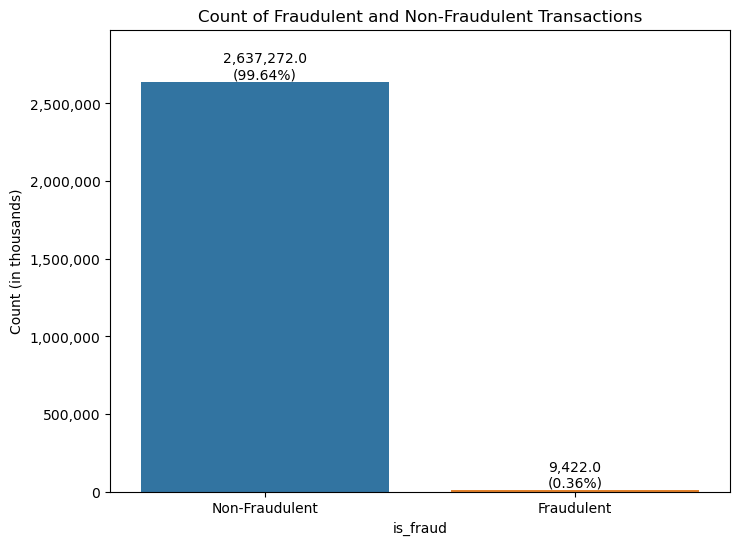

In [ ]:
# Fraud distribution
print("Fraud Distribution:")
fraud_counts = df1['is_fraud'].value_counts()
print(fraud_counts)

# Fraud rate
fraud_rate = df1['is_fraud'].mean()
print(f"Fraud Rate: {fraud_rate:.4f} ({fraud_rate * 100:.2f}%)")

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='is_fraud')

# Customize the plot
ax.set_ylabel('Count (in thousands)')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title('Count of Fraudulent and Non-Fraudulent Transactions')
ax.set_xticks([0, 1])  # Set x-ticks
ax.set_xticklabels(['Non-Fraudulent', 'Fraudulent'])  # Label x-axis

# Extend y-axis limits slightly for readability
plt.ylim(0, max(fraud_counts) * 1.1)
# Add count and percentage on the bars
total_count = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position (center of the bar)
        height + 1000,  # Y position (slightly above the bar)
        f'{height:,}\n({percentage:.2f}%)',  # Text (count and percentage)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10
    )

plt.show()

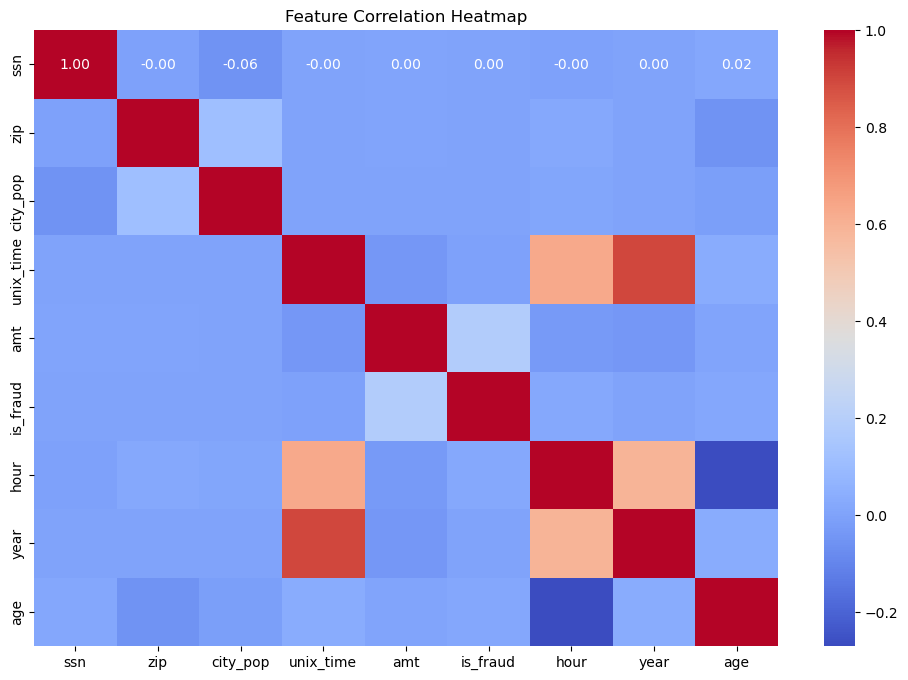

In [15]:
# Correlation heat map
df_numeric = df1.select_dtypes(include=['number'])

# Create the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

### Fraudulent transactions by hour

In [8]:
# Get fraudulent transactions by hour
hour_fraud = df1.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0).reset_index(names=['hour', 0, 1])
hour_fraud.columns.name = None

#  Display the count of fraud by hour
print("Fraud Count by Hour:")
hour_fraud

Fraud Count by Hour:


,hour,0,1
0,0,83693,666
1,1,83202,665
2,2,83214,632
3,3,83660,656
4,4,83786,48
5,5,84056,46
6,6,83781,56
7,7,83892,49
8,8,83972,55
9,9,83696,44


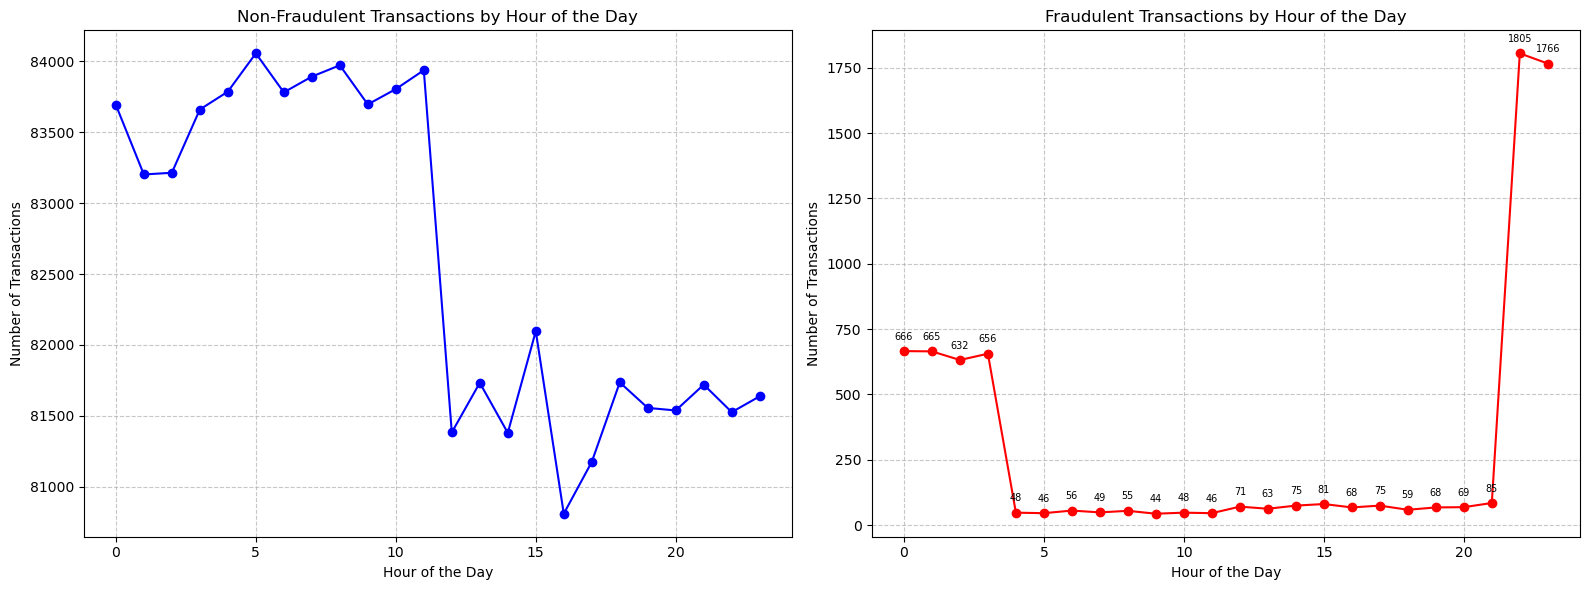

In [9]:
# Create subplots for hour analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Non-Fraudulent Transactions by hour
axes[0].plot(hour_fraud.index, hour_fraud[0], color='blue', marker='o')
axes[0].set_title('Non-Fraudulent Transactions by Hour of the Day')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Transactions')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Add data point values: Too cramped and not as useful
'''for x, y in zip(hour_fraud['hour'], hour_fraud[0]):
    axes[0].text(x, y+max(hour_fraud[0])*0.02, f'{int(y)}', 
             ha='center', va='bottom', fontsize=8)'''
    
# Plot Fraudulent Transactions by hour
axes[1].plot(hour_fraud.index, hour_fraud[1], color='red', marker='o')
axes[1].set_title('Fraudulent Transactions by Hour of the Day')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Number of Transactions')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Add data point values
for x, y in zip(hour_fraud['hour'], hour_fraud[1]):
    axes[1].text(x, y+max(hour_fraud[1])*0.02, f'{int(y)}', 
             ha='center', va='bottom', fontsize=7)
    

plt.tight_layout()
plt.show()

In [10]:
# Group by unix_time and count transactions
time_grouped = df1.groupby('unix_time').agg(
    num_transactions=('trans_num', 'size'),
    num_unique_customers=('ssn', 'nunique'),
    num_unique_merchants=('merchant', 'nunique'),
    num_fraud=('is_fraud', 'sum'),
).reset_index()

# Filter for times with multiple transactions
suspicious_times = time_grouped[time_grouped['num_transactions'] > 1].sort_values(by='num_transactions', ascending=False)

# Display the top 10 suspicious times
print("Top 10 Suspicious unix_time with multiple transactions:")
print(suspicious_times.head(10))

# results show that despite sharing unix_time, most of these transactions seem to be all unique and independent,
# hence unlikely to be coordinated fraud. Could be due to peak shopping times or other reasons.  

Top 10 Suspicious unix_time with multiple transactions:
         unix_time  num_transactions  num_unique_customers  \
829445  1640427909                 5                     5   
491215  1628990684                 4                     4   
376979  1625265945                 4                     4   
343805  1624137368                 4                     4   
109192  1615077286                 4                     4   
471629  1628374273                 4                     4   
359547  1624669374                 4                     4   
558446  1631405689                 4                     4   
281668  1622147799                 4                     4   
178987  1617998927                 4                     4   

        num_unique_merchants  num_fraud  
829445                     5          0  
491215                     4          0  
376979                     4          0  
343805                     4          0  
109192                     4          0  
471629   

### Fraudulent transactions by day of the week

**Weekday transactions are more likely to be fraudulent**

Although there are more transactions on weekends, the fraud count on both weekday and weekends are relatively similar, resulting in fraudulent transactions making up a larger part of all transactions on weekdays

In [66]:
def plot_by_week(df, feature, title, y_label, label_func):
    # Plot fraud count by day of week
    plt.figure(figsize=(12, 6))

    # Set different colors for weekdays and weekends
    colors = ['blue' if is_weekend == 0 else 'red' for is_weekend in df['Is_Weekend']]

    plt.plot(df['day_of_week'], df[feature], 
            marker='o', linestyle='-', color='purple', linewidth=2)

    # Add bars with different colors for weekday/weekend
    plt.bar(df['day_of_week'], df[feature], 
            alpha=0.3, color=colors)

    # Add title and labels
    plt.title(f"{title}", fontsize=16)
    plt.xlabel("Day of Week", fontsize=12)
    plt.ylabel(f"{y_label}", fontsize=12)

    # Add legend
    legend_elements = [
        Patch(facecolor='blue', alpha=0.3, label='Weekday'),
        Patch(facecolor='red', alpha=0.3, label='Weekend')
    ]
    plt.legend(handles=legend_elements)

    # Add value labels above each bar
    for i, count in enumerate(df[feature]):
        plt.text(i, count + max(df[feature])*0.02, label_func(count), 
                ha='center', fontsize=10)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')

    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()

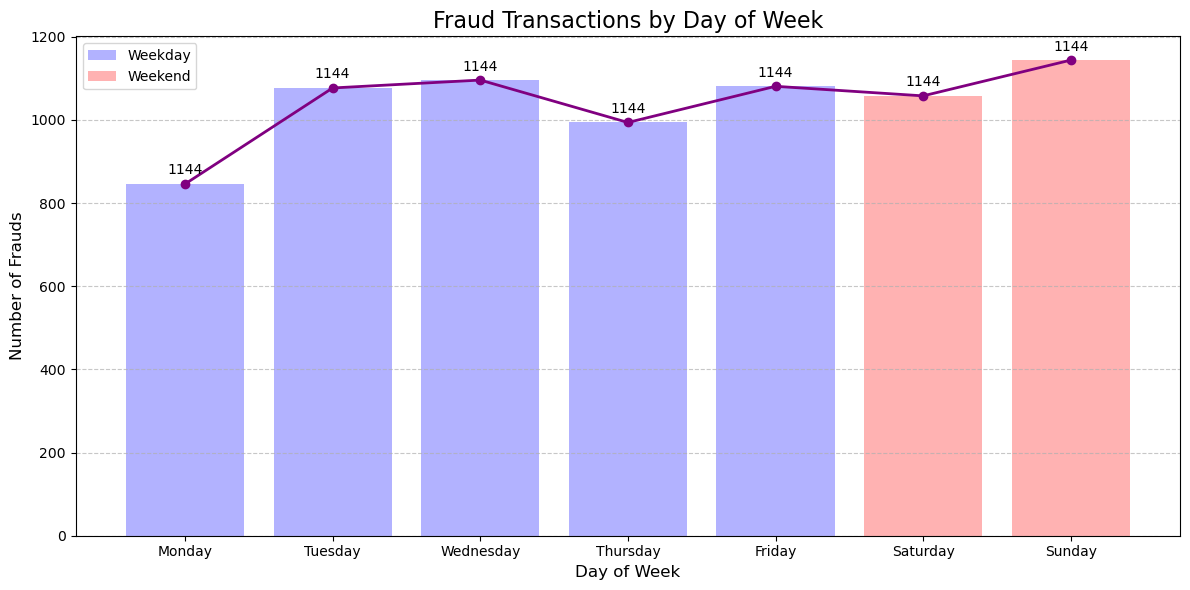

Total Weekday Frauds: 5094
Total Weekend Frauds: 2202
Weekday Average (per day): 1018.80
Weekend Average (per day): 1101.00


In [67]:
# Filter for fraud by day of week
fraud_daily_df = fraud_filter('day_of_week')
fraud_daily_df['Is_Weekend'] = [0, 0, 0, 0, 0, 1, 1] # 0 for weekday, 1 for weekend

def label_fraud_counts(df):
    return f'{int(count)}'

plot_by_week(fraud_daily_df, 'fraud_count', 'Fraud Transactions by Day of Week', 'Number of Frauds', label_fraud_counts)

# Print summary of weekday vs weekend
weekday_fraud = fraud_daily_df[fraud_daily_df['Is_Weekend'] == 0]['fraud_count'].sum()
weekend_fraud = fraud_daily_df[fraud_daily_df['Is_Weekend'] == 1]['fraud_count'].sum()

print(f"Total Weekday Frauds: {int(weekday_fraud)}")
print(f"Total Weekend Frauds: {int(weekend_fraud)}")
print(f"Weekday Average (per day): {weekday_fraud/5:.2f}")
print(f"Weekend Average (per day): {weekend_fraud/2:.2f}")

In [71]:
# Total transactions by day of week
daily_df = df1.groupby('day_of_week').size().reset_index(name='total')
daily_df = daily_df.merge(fraud_daily_df, on='day_of_week')
daily_df['Percentage'] = daily_df['fraud_count']/daily_df['total']*100

# Print summary of weekday vs weekend
weekday_total = daily_df[fraud_daily_df['Is_Weekend'] == 0]['total'].sum()
weekend_total = daily_df[fraud_daily_df['Is_Weekend'] == 1]['total'].sum()

print(f"Total Weekday Transactions: {int(weekday_total)}")
print(f"Total Weekend Transactions: {int(weekend_total)}")
print(f"Weekday Average (per day): {weekday_total/5:.2f}")
print(f"Weekend Average (per day): {weekend_total/2:.2f}")

Total Weekday Transactions: 1190605
Total Weekend Transactions: 799676
Weekday Average (per day): 238121.00
Weekend Average (per day): 399838.00


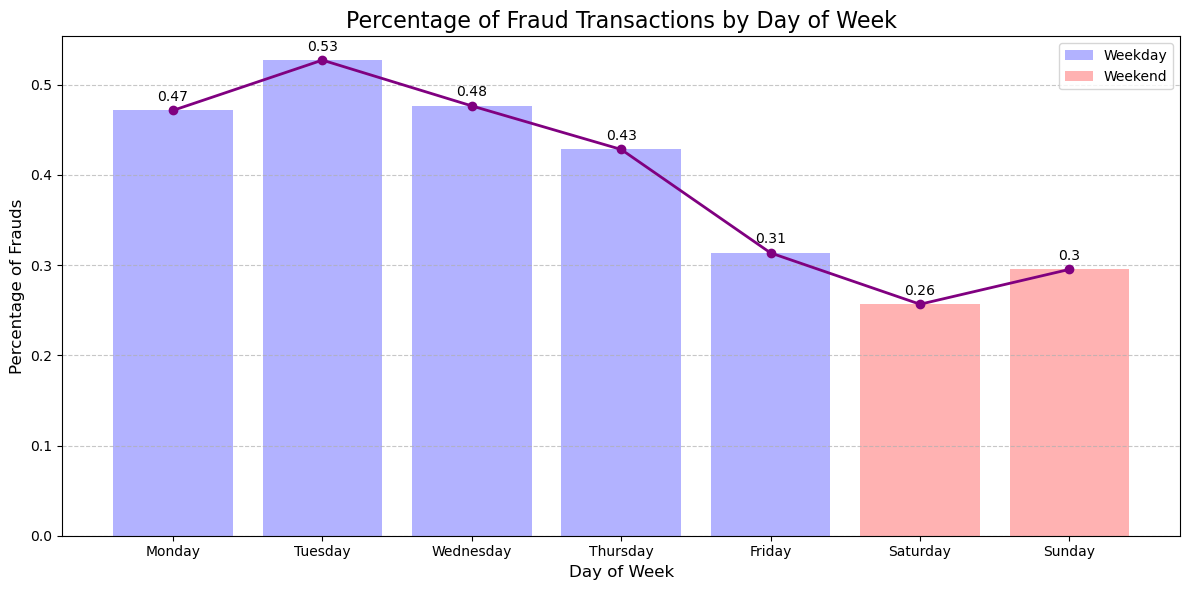

In [70]:
# Check percentage of fraudulent transactions separated by day
def label_fraud_counts(count):
    return f'{round(count, 2)}'

plot_by_week(daily_df, 'Percentage', 'Percentage of Fraud Transactions by Day of Week', 'Percentage of Frauds', label_fraud_counts)

### Fraudulent transactions by date

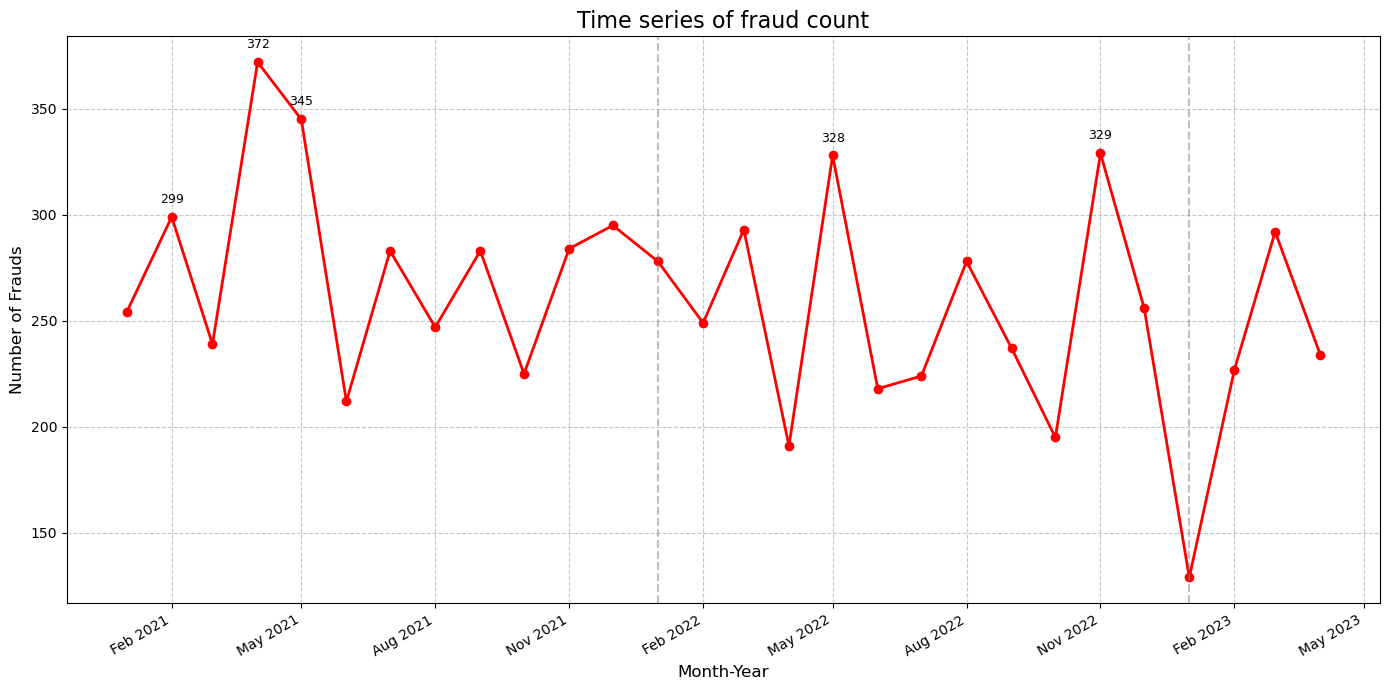

Total number of frauds: 7296
Month with most frauds: Apr 2021 (372 frauds)
Month with least frauds: Jan 2023 (129 frauds)


In [12]:
# Overview of fraud counts by month
fraud_count_df = df1[["month", "is_fraud"]].groupby(by = "month", as_index = False).sum().rename(columns={'month':'Date', 'is_fraud':'Fraud_Count'}).sort_values('Date')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(fraud_count_df['Date'], fraud_count_df['Fraud_Count'], 
         marker='o', linestyle='-', color='red', linewidth=2)

# Format x-axis to show month and year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show every 3 months
plt.gcf().autofmt_xdate()  # Rotate date labels

# Add title and labels
plt.title("Time series of fraud count", fontsize=16)
plt.xlabel("Month-Year", fontsize=12)
plt.ylabel("Number of Frauds", fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Highlight year transitions with vertical lines
years = fraud_count_df['Date'].dt.year.unique()
for year in years[1:]:  # Skip the first year
    plt.axvline(pd.Timestamp(f"{year}-01-01"), color='gray', linestyle='--', alpha=0.5)

# Add data annotations for peak points
peak_threshold = fraud_count_df['Fraud_Count'].max() * 0.8
peaks = fraud_count_df[fraud_count_df['Fraud_Count'] >= peak_threshold]
for i, row in peaks.iterrows():
    plt.annotate(f"{int(row['Fraud_Count'])}", 
                 (row['Date'], row['Fraud_Count']),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 fontsize=9)

# Show the plot
plt.tight_layout()
plt.show()

# Print summary statistics using existing data
print(f"Total number of frauds: {fraud_count_df['Fraud_Count'].sum()}")
print(f"Month with most frauds: {fraud_count_df.loc[fraud_count_df['Fraud_Count'].idxmax(), 'Date'].strftime('%b %Y')} "
      f"({int(fraud_count_df['Fraud_Count'].max())} frauds)")
print(f"Month with least frauds: {fraud_count_df.loc[fraud_count_df['Fraud_Count'].idxmin(), 'Date'].strftime('%b %Y')} "
      f"({int(fraud_count_df['Fraud_Count'].min())} frauds)")


<Figure size 800x600 with 0 Axes>

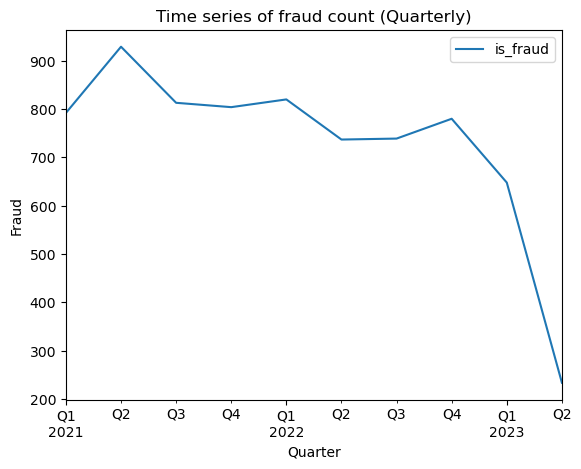

In [13]:
# Fraud counts on quarterly basis
time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").sum()

plt.figure(figsize=(8, 6))
time_num_frauds.plot()
plt.title('Time series of fraud count (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Fraud')
plt.show()

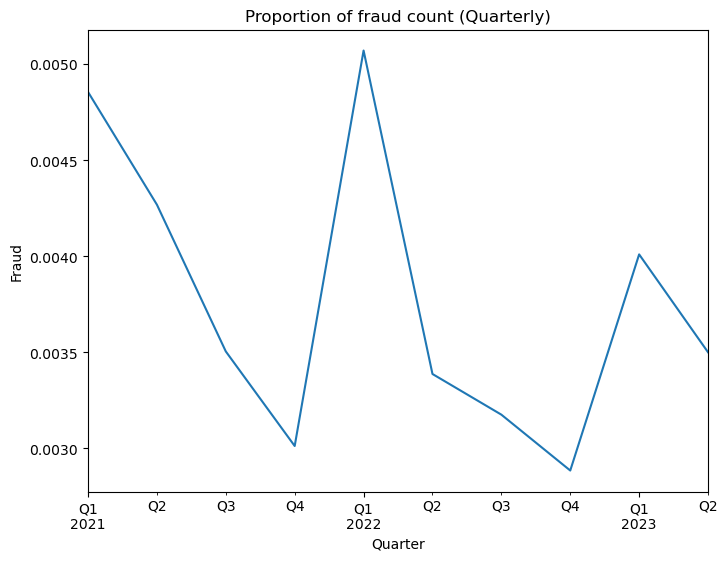

In [14]:
# Proportion of fraud (quarterly)
time_num_frauds = df1[["trans_quarter", "is_fraud"]].groupby(by = "trans_quarter").apply(lambda x: x["is_fraud"].sum()/len(x))

plt.figure(figsize=(8, 6))
time_num_frauds.plot()
plt.title('Proportion of fraud count (Quarterly)')
plt.xlabel('Quarter')
plt.ylabel('Fraud')
plt.show()

**Unlikely that fraud is committed by duplicate transactions**

While there are non-negligible numbers of fraudulent transactions with duplicate time, there are relatively few cases associated with any customer or merchant.

In [23]:
# Check if there is fraud related to transaction time
unix_count = df1.groupby('unix_time')['unix_time'].count().reset_index(name='count').sort_values('count', ascending=False)
unix_count = unix_count[unix_count['count'] > 1]['unix_time']

duplicated_unix_time = df1[df1['unix_time'].isin(unix_count)].sort_values('unix_time')
duplicated_unix_time

,ssn,gender,city,state,zip,city_pop,job,dob,trans_num,trans_date,...,is_fraud,merchant,hour,day_of_week,month,trans_quarter,year,age,age_group,city_state
2576115,24730528,F,Dallas,TX,75252,1263321,Embryologist,2000-12-21,d2934c32d62f713bb2e932c9533ddeb7,2021-01-01,...,0,Bins-Rice,0,Friday,2021-01-01,2021Q1,2021,20,20-30,"Dallas, TX"
1058234,804928268,F,Avon,CT,6001,18385,Music therapist,1988-06-17,0c16b3123f3c2d389d06bd60195772e5,2021-01-01,...,0,Cummings LLC,0,Friday,2021-01-01,2021Q1,2021,32,30-40,"Avon, CT"
389317,568920313,F,Wickes,AR,71973,1424,Engineer,1966-05-25,78afaba23b8923760dbd8e7182396a99,2021-01-01,...,0,Christiansen,0,Friday,2021-01-01,2021Q1,2021,54,50-60,"Wickes, AR"
984222,158908788,M,Gibsonia,PA,15044,27049,Designer,2000-12-06,07442d6386a857808fa90ff4b2ff2602,2021-01-01,...,0,Raynor,0,Friday,2021-01-01,2021Q1,2021,20,20-30,"Gibsonia, PA"
1789554,195330728,M,Green Bay,WI,54313,179116,Optician,1967-08-14,61abc0ef38bbe6999d303c0f3861ae03,2021-01-01,...,0,Robel,0,Friday,2021-01-01,2021Q1,2021,53,50-60,"Green Bay, WI"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082492,52700973,F,Waukesha,WI,53189,95015,Forest/woodland manager,1976-01-22,5382c6e08aa38a5e2b8c7d16a59ed345,2023-04-30,...,0,Gerhold LLC,23,Sunday,2023-04-01,2023Q2,2023,47,40-50,"Waukesha, WI"
289503,153959493,M,Dallas,GA,30132,79338,Warden/ranger,1965-04-04,5ff7b287823c2448b7f244105e5f8223,2023-04-30,...,0,Stark-Koss,23,Sunday,2023-04-01,2023Q2,2023,58,50-60,"Dallas, GA"
1616897,91264088,M,Avon Lake,OH,44012,22581,Immunologist,1998-08-30,653022225555bd64e9bd23d75206e60d,2023-04-30,...,0,Terry Ltd,23,Sunday,2023-04-01,2023Q2,2023,24,20-30,"Avon Lake, OH"
1461539,235063634,F,Toms River,NJ,8755,122197,Surveyor,1951-01-21,e58ba362ed9007fb87be0f5b91734fc0,2023-04-30,...,0,Denesik,23,Sunday,2023-04-01,2023Q2,2023,72,70-80,"Toms River, NJ"


In [24]:
# Identify merchants with fraudulent transactions at duplicate times
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['merchant'])['merchant'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,merchant,count
114,Reichert,5
107,Pacocha-O'Reilly,4
118,Romaguera,4
106,O'Keefe-Hudson,4
21,Connelly,3
54,Heller,3
65,Huel-Langworth,3
24,Cormier LLC,2
13,Bogisich Inc,2
16,Boyer PLC,2


In [25]:
# Identify ssn with fraudulent transactions at duplicate times
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['ssn'])['ssn'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,ssn,count
144,805105003,4
17,86372495,3
160,883641316,3
158,872212853,3
86,486855972,3
40,255195413,2
13,65212389,2
26,131065051,2
34,222352160,2
1,11788315,2


**Fraudulent transactions tend to happen on the same day**

An analysis of customers' daily fraud rates (proportion of transactions that are fraud each day) reveals that for a given day, either none of a customer's transactions are fraudulent or all of their transactions are fraudulent. This means that fraudulent transactions tend to be conducted on the same day, and usually 3-5 transactions are made on these days,

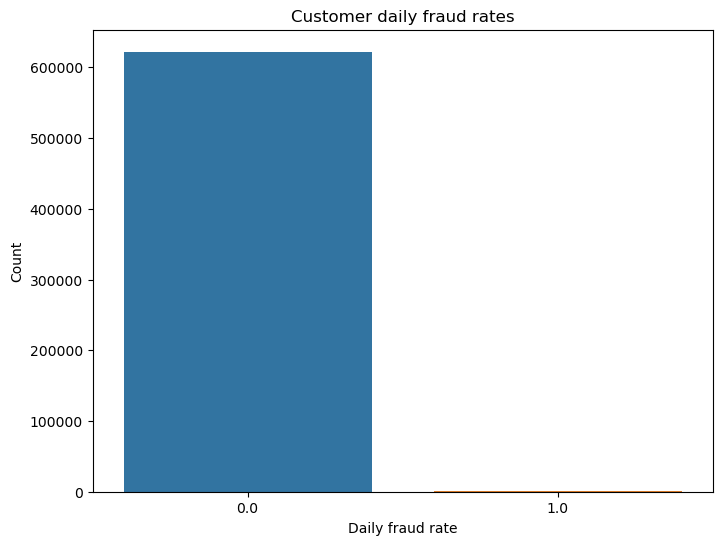

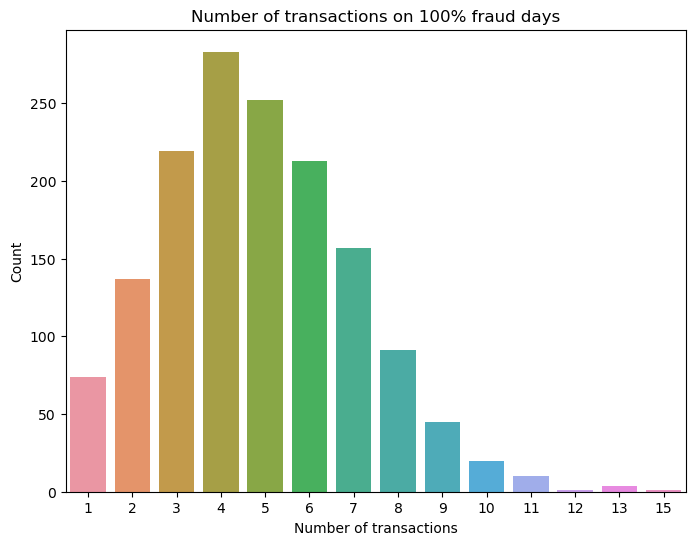

In [26]:
# Calculate customer daily fraud rate
customer_date_fraud = df1.groupby(['ssn', 'trans_date'])['is_fraud'].agg(['mean', 'count']).reset_index()
# Create count of daily fraud rates
customer_date_fraud_stats = customer_date_fraud['mean'].value_counts().reset_index(name = 'count')

# Plot bargraph
plt.figure(figsize = (8,6))
sns.barplot(data = customer_date_fraud_stats, x = 'mean', y = 'count')
plt.title('Customer daily fraud rates')
plt.xlabel('Daily fraud rate')
plt.ylabel('Count')
plt.show()

# Filter out 100% fraud days and count number of transactions
customer_date_fraud_num = customer_date_fraud.loc[customer_date_fraud['mean'] != 0, 'count'].value_counts().reset_index(name = 'num_trans')

# Plot bargraph
plt.figure(figsize = (8,6))
sns.barplot(data = customer_date_fraud_num, x = 'count', y = 'num_trans')
plt.title('Number of transactions on 100% fraud days')
plt.xlabel('Number of transactions')
plt.ylabel('Count')
plt.show()


**Fraud attacks typically only last 1-2 days and each customer is only affected once.**

In [15]:
# Filter for fraudulent transactions only
fraud_df = df1.loc[df1['is_fraud'] == 1]

# Find unique dates where each person had a fraudulent transaction
fraud_dates = fraud_df[['ssn', 'trans_date']].drop_duplicates().sort_values(['ssn', 'trans_date'])
# Find interval between successive fraud attacks
fraud_dates['prev_fraud'] = fraud_dates.groupby('ssn').shift(1)['trans_date']
fraud_dates['interval'] = (fraud_dates['trans_date'] - fraud_dates['prev_fraud']).dt.days

# Filter for fraud attacks that lasted more than 1 day
fraud_multiday = fraud_dates.dropna()
# Rename columns to reflect start and end date of attack
fraud_multiday = fraud_multiday.rename({'trans_date':'end_date', 
                      'prev_fraud':'start_date'}, axis = 1)

# Filter for fraud attacks that lasted only 1 day
fraud_1_day = fraud_dates.loc[fraud_dates['prev_fraud'].isna()]
# Add 'end_date' column that holds same value as 'trans_date
fraud_1_day['end_date'] = fraud_1_day['trans_date']
# Add 'interval' column 
fraud_1_day['interval'] = (fraud_1_day['end_date'] - fraud_1_day['trans_date']).dt.days
fraud_1_day = fraud_1_day.rename({'trans_date':'start_date'}, axis = 1)
fraud_1_day = fraud_1_day.drop(['prev_fraud'], axis = 1)

# Combine both dfs into 1
fraud_periods = pd.concat([fraud_multiday, fraud_1_day])    
fraud_periods = fraud_periods[['ssn', 'start_date', 'end_date', 'interval']]
fraud_periods = fraud_periods.sort_values(['end_date'], ascending = False).groupby(['ssn', 'start_date']).first()
print('All customers are only attacked once')
print(fraud_periods.groupby('ssn').size().reset_index(name = 'total_attacks')['total_attacks'].value_counts().reset_index(name = 'count'))

# Find actual period of fraud attack by adding 1 to interval column
fraud_periods['fraud_period'] = fraud_periods['interval'] + 1
print('\nEach fraud attack lasts only 1 or 2 days')
print(fraud_periods['fraud_period'].value_counts().reset_index(name = 'count'))
# fraud_periods = pd.melt(fraud_periods, id_vars = ['ssn', 'fraud_period'], value_vars = ['start_date', 'end_date'], value_name = 'trans_date')

All customers are only attacked once
   total_attacks  count
0              1    761

Each fraud attack lasts only 1 or 2 days
   fraud_period  count
0           2.0    746
1           1.0     15


 ### Warm up and cool down periods (customers)

In [28]:
# Graph of warm up and cool down periods. Warm up period refer to no. of days between first normal transaction and first fradulent transactions.
# Cool down refers to no. of days between their very last fruadulent transaction and overall last transaction.
def calculate_periods(df):
    first_trans = df.sort_values(['trans_date', 'trans_time']).groupby('ssn').first()
    last_trans = df.sort_values(['trans_date', 'trans_time']).groupby('ssn').last()
    
    first_fraud = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('ssn').first()
    last_fraud = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('ssn').last()
    
    # Merge the DataFrames
    periods = pd.DataFrame(index=first_fraud.index)
    periods['first_trans_date'] = first_trans['trans_date']
    periods['last_trans_date'] = last_trans['trans_date']
    periods['first_fraud_date'] = first_fraud['trans_date']
    periods['last_fraud_date'] = last_fraud['trans_date']
    
    # Calculate periods in days
    periods['warmup_days'] = (periods['first_fraud_date'] - periods['first_trans_date']).dt.days
    periods['cooldown_days'] = (periods['last_trans_date'] - periods['last_fraud_date']).dt.days
    
    # Categorize periods for graph
    def categorize_period(days):
        if days == 0:
            return '0 days'
        elif 1 <= days <= 30:
            return '1 - 30 days'
        else:
            return '> 30 days'
    
    periods['warmup_period_grp'] = periods['warmup_days'].apply(categorize_period)
    periods['cooldown_period_grp'] = periods['cooldown_days'].apply(categorize_period)
    
    return periods

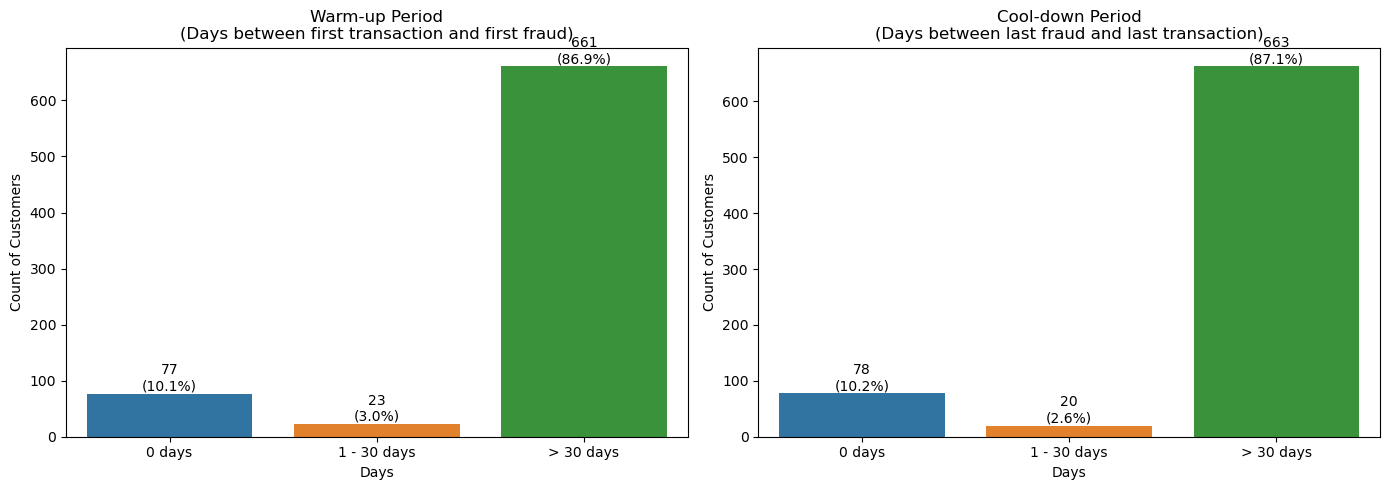

Warm-up Period Summary (days between first transaction and first fraud):
  warmup_period_grp  count
0            0 days     77
1       1 - 30 days     23
2         > 30 days    661

Cool-down Period Summary (days between last fraud and last transaction):
  cooldown_period_grp  count
0              0 days     78
1         1 - 30 days     20
2           > 30 days    663

Percentage of customers whose first transaction was fraudulent:
10.1% (77 customers)

Percentage of customers whose last transaction was fraudulent:
10.2% (78 customers)


In [29]:
# Calculate periods
fraud_customer_periods = calculate_periods(df1)

# Create the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})

order = ['0 days', '1 - 30 days', '> 30 days']

# Plot warmup period 
warmup_counts = fraud_customer_periods['warmup_period_grp'].value_counts().reindex(order).reset_index()
warmup_counts.columns = ['warmup_period_grp', 'count']

sns.barplot(
    data=warmup_counts, 
    x='warmup_period_grp', 
    y='count', 
    ax=axes[0], 
    order=order
)
axes[0].set_title('Warm-up Period\n(Days between first transaction and first fraud)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Count of Customers')

# Add labels
total_customers = warmup_counts['count'].sum()
for i, p in enumerate(axes[0].patches):
    count = warmup_counts.iloc[i]['count']
    percentage = (count / total_customers) * 100
    axes[0].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Plot cooldown period
cooldown_counts = fraud_customer_periods['cooldown_period_grp'].value_counts().reindex(order).reset_index()
cooldown_counts.columns = ['cooldown_period_grp', 'count']

sns.barplot(
    data=cooldown_counts, 
    x='cooldown_period_grp', 
    y='count', 
    ax=axes[1], 
    order=order
)
axes[1].set_title('Cool-down Period\n(Days between last fraud and last transaction)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Count of Customers')

# Add labels
total_customers = cooldown_counts['count'].sum()
for i, p in enumerate(axes[1].patches):
    count = cooldown_counts.iloc[i]['count']
    percentage = (count / total_customers) * 100
    axes[1].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Warm-up Period Summary (days between first transaction and first fraud):")
print(warmup_counts)

print("\nCool-down Period Summary (days between last fraud and last transaction):")
print(cooldown_counts)

# Additional insights
print("\nPercentage of customers whose first transaction was fraudulent:")
first_fraud_pct = (fraud_customer_periods['warmup_days'] == 0).mean() * 100
print(f"{first_fraud_pct:.1f}% ({(fraud_customer_periods['warmup_days'] == 0).sum()} customers)")

print("\nPercentage of customers whose last transaction was fraudulent:")
last_fraud_pct = (fraud_customer_periods['cooldown_days'] == 0).mean() * 100
print(f"{last_fraud_pct:.1f}% ({(fraud_customer_periods['cooldown_days'] == 0).sum()} customers)")

 ### Warm up and cool down periods (merchants)

In [30]:
# Graph of warm up and cool down periods for merchants
def calculate_periods_merchants(df):
    first_trans_merchant = df.sort_values(['trans_date', 'trans_time']).groupby('merchant').first()
    last_trans_merchant = df.sort_values(['trans_date', 'trans_time']).groupby('merchant').last()
    
    first_fraud_merchant = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('merchant').first()
    last_fraud_merchant = df[df['is_fraud'] == 1].sort_values(['trans_date', 'trans_time']).groupby('merchant').last()
    
    # Merge the DataFrames
    periods_merchant = pd.DataFrame(index=first_fraud_merchant.index)
    periods_merchant['first_trans_date'] = first_trans_merchant['trans_date']
    periods_merchant['last_trans_date'] = last_trans_merchant['trans_date']
    periods_merchant['first_fraud_date'] = first_fraud_merchant['trans_date']
    periods_merchant['last_fraud_date'] = last_fraud_merchant['trans_date']
    
    # Calculate periods in days
    periods_merchant['warmup_days'] = (periods_merchant['first_fraud_date'] - periods_merchant['first_trans_date']).dt.days
    periods_merchant['cooldown_days'] = (periods_merchant['last_trans_date'] - periods_merchant['last_fraud_date']).dt.days
    
    # Categorize periods for graph
    def categorize_period(days):
        if days == 0:
            return '0 days'
        elif 1 <= days <= 30:
            return '1 - 30 days'
        else:
            return '> 30 days'
    
    periods_merchant['warmup_period_grp'] = periods_merchant['warmup_days'].apply(categorize_period)
    periods_merchant['cooldown_period_grp'] = periods_merchant['cooldown_days'].apply(categorize_period)
    
    return periods_merchant

# Calculate periods
fraud_merchant_periods = calculate_periods_merchants(df1)

There are 648 unique merchants. 632 of them have been involved in fraud.


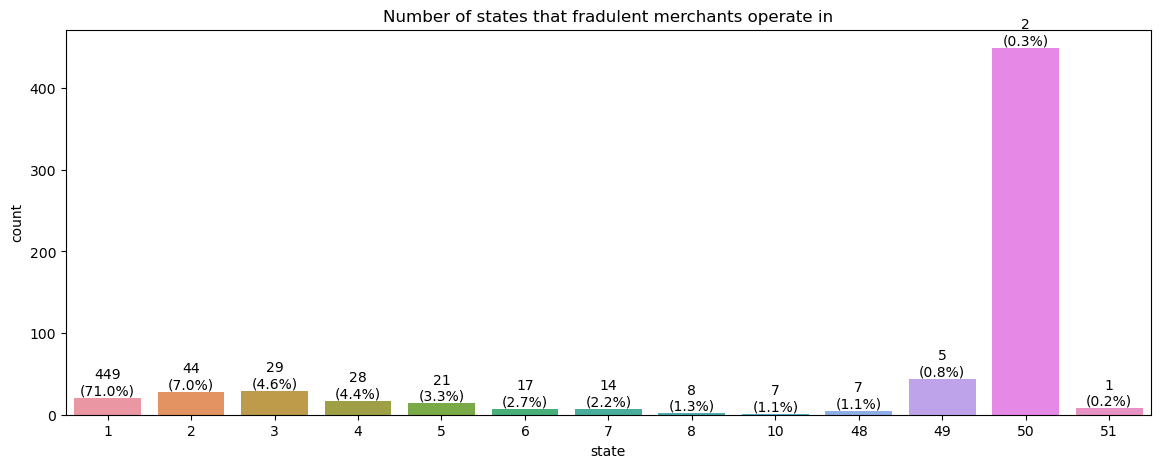

Most fradulent merchants operate in almost all states.


In [31]:
print(f"There are {len(df['merchant'].unique())} unique merchants. {len(fraud_merchant_periods)} of them have been involved in fraud.")

# Calculate number of states that fradulent merchants operates in
merchant_state = df1.loc[df1['merchant'].isin(fraud_merchant_periods.index)].groupby('merchant').nunique()['state'].reset_index()
# Tally state count
state_count = merchant_state['state'].value_counts().reset_index()

# Plot the bar plot
fig, ax = plt.subplots(figsize = (14,5))
sns.barplot(data = state_count, x = 'state', y = 'count', ax = ax)

total_merchants = state_count['count'].sum()
for i, p in enumerate(ax.patches):
    count = state_count.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    ax.annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')
    
ax.set_title('Number of states that fradulent merchants operate in')
plt.show()

# Print analysis
print('Most fradulent merchants operate in almost all states.')

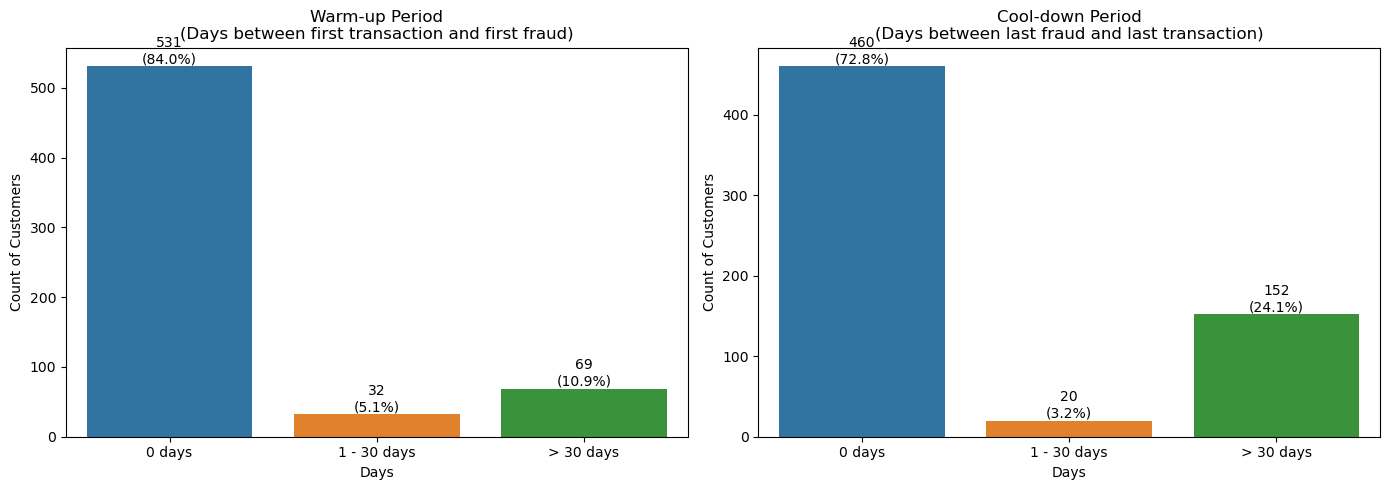

Warm-up Period Summary (days between first transaction and first fraud):
  warmup_period_grp  count
0            0 days    531
1       1 - 30 days     32
2         > 30 days     69

Cool-down Period Summary (days between last fraud and last transaction):
  cooldown_period_grp  count
0              0 days    460
1         1 - 30 days     20
2           > 30 days    152

Percentage of merchants whose first transaction was fraudulent:
84.0% (531 merchants)

Percentage of merchants whose last transaction was fraudulent:
72.8% (460 merchants)


In [32]:

# Create the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})

order = ['0 days', '1 - 30 days', '> 30 days']

# Plot warmup period 
warmup_counts_merchant = fraud_merchant_periods['warmup_period_grp'].value_counts().reindex(order).reset_index()
warmup_counts_merchant.columns = ['warmup_period_grp', 'count']

sns.barplot(
    data=warmup_counts_merchant, 
    x='warmup_period_grp', 
    y='count', 
    ax=axes[0], 
    order=order
)
axes[0].set_title('Warm-up Period\n(Days between first transaction and first fraud)')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Count of Customers')

# Add labels
total_merchants = warmup_counts_merchant['count'].sum()
for i, p in enumerate(axes[0].patches):
    count = warmup_counts_merchant.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    axes[0].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

# Plot cooldown period
cooldown_counts_merchant = fraud_merchant_periods['cooldown_period_grp'].value_counts().reindex(order).reset_index()
cooldown_counts_merchant.columns = ['cooldown_period_grp', 'count']

sns.barplot(
    data=cooldown_counts_merchant, 
    x='cooldown_period_grp', 
    y='count', 
    ax=axes[1], 
    order=order
)
axes[1].set_title('Cool-down Period\n(Days between last fraud and last transaction)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Count of Customers')

# Add labels
total_merchants = cooldown_counts_merchant['count'].sum()
for i, p in enumerate(axes[1].patches):
    count = cooldown_counts_merchant.iloc[i]['count']
    percentage = (count / total_merchants) * 100
    axes[1].annotate(f'{count}\n({percentage:.1f}%)', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Warm-up Period Summary (days between first transaction and first fraud):")
print(warmup_counts_merchant)

print("\nCool-down Period Summary (days between last fraud and last transaction):")
print(cooldown_counts_merchant)

# Additional insights
print("\nPercentage of merchants whose first transaction was fraudulent:")
merchant_first_fraud_pct = (fraud_merchant_periods['warmup_days'] == 0).mean() * 100
print(f"{merchant_first_fraud_pct:.1f}% ({(fraud_merchant_periods['warmup_days'] == 0).sum()} merchants)")

print("\nPercentage of merchants whose last transaction was fraudulent:")
merchant_last_fraud_pct = (fraud_merchant_periods['cooldown_days'] == 0).mean() * 100
print(f"{merchant_last_fraud_pct:.1f}% ({(fraud_merchant_periods['cooldown_days'] == 0).sum()} merchants)")

It appears that fraudulent merchants are likely to immediately get involved in fraud and also stop transacting after the last fraud transaction.

This could lead to a hypothesis that some of these merchant accounts were created by fraudsters solely for the purpose of pulling off these frauds.

### Fraudulent transactions by location

In [33]:
# Proportion of fraudulent transactions by state
fraud_prop_by_state = df1.groupby('state')['is_fraud'].mean().reset_index(name = 'fraud_prop')
# Apply log transformation to normalize data for easy visualization
fraud_prop_by_state['log_prop'] = np.log(fraud_prop_by_state['fraud_prop'])/np.log(0.0001)

# Plot interactive map
fig = px.choropleth(fraud_prop_by_state, 
                     locations="state", 
                     locationmode="USA-states", 
                     color="log_prop", 
                     scope="usa",
                     color_continuous_scale="Viridis")
fig.show()


**Higher population leads to higher number of fraud cases**

May be because it is easier to commit fraud in a large city.

From the data, it shows that cities with a larger population leads to greater number of frauds from the best fit line.

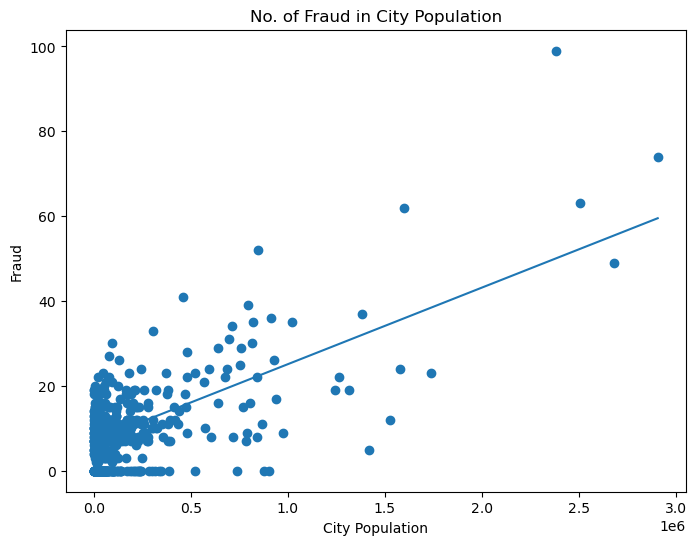

In [34]:
# Fraud count per city_pop. 
# Check if higher population leads to higher fraud cases
fraud_count = df1.groupby('city_pop')['is_fraud'].sum().reset_index()

a, b = np.polyfit(fraud_count["city_pop"], fraud_count["is_fraud"], 1)

plt.figure(figsize=(8, 6))
plt.scatter('city_pop','is_fraud', data=fraud_count)
plt.plot(fraud_count["city_pop"], a * fraud_count["city_pop"] + b)
plt.title('No. of Fraud in City Population')
plt.xlabel('City Population')
plt.ylabel('Fraud')
plt.show()

**Some cities are more popular for committing fraud**

Top 5 States by Fraud Percentage:
state  fraud_percentage  fraud_count  total_transactions
   DC        100.000000            8                   8
   ME          0.775827           19                2449
   RI          0.672166           22                3273
   NH          0.665658           44                6610
   IA          0.524581           78               14869

Bottom 5 States by Fraud Percentage:
state  fraud_percentage  fraud_count  total_transactions
   VT          0.122164            7                5730
   NV          0.132641           24               18094
   NE          0.155954           37               23725
   MT          0.167820           32               19068
   WY          0.172536           17                9853

Top 3 States with Highest Fraud Variability:
state  fraud_std  fraud_percentage  fraud_count
   ME   0.087739          0.775827           19
   RI   0.081710          0.672166           22
   NH   0.081316          0.665658           44

Botto

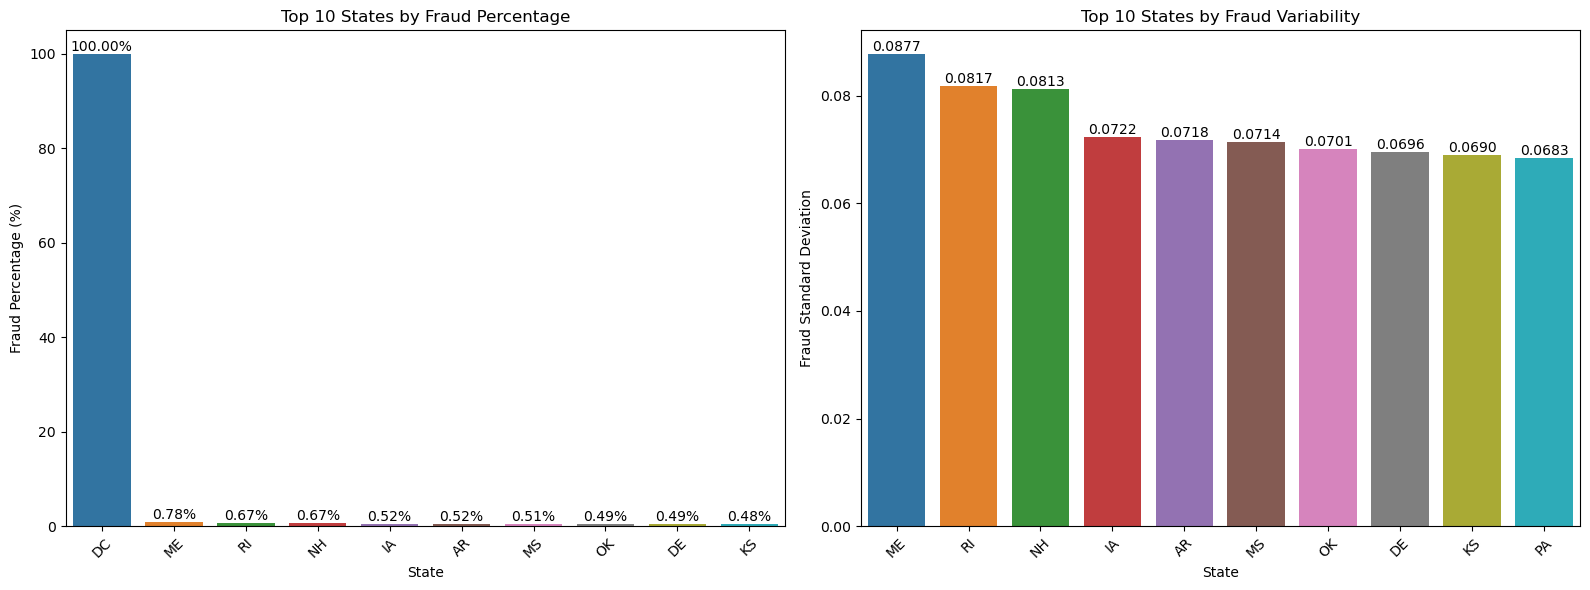

In [35]:
def analyze_fraud_variability(df1):
    # Group by state and calculate fraud metrics
    fraud_by_state = df1.groupby('state').agg({
        'is_fraud': [
            ('fraud_count', lambda x: (x == 1).sum()),
            ('total_transactions', 'count'),
            ('fraud_std', lambda x: np.std(x))  # Calculate fraud sd
        ],
        'amt': [
            ('total_amount', 'sum'),
            ('fraud_amount', lambda x: x[df1['is_fraud'] == 1].sum()),
            ('fraud_amount_std', lambda x: np.std(x[df1['is_fraud'] == 1]))
        ]
    }).reset_index()
    
    # Flatten column names
    fraud_by_state.columns = [
        'state', 'fraud_count', 'total_transactions', 
        'fraud_std', 'total_amount', 'total_fraud_amount', 'fraud_amount_std'
    ]
    
    # Calculate fraud percentage
    fraud_by_state['fraud_percentage'] = (fraud_by_state['fraud_count'] / fraud_by_state['total_transactions']) * 100
    
    # Sort states by different metrics
    top_fraud_percentage = fraud_by_state.nlargest(5, 'fraud_percentage')
    bottom_fraud_percentage = fraud_by_state.nsmallest(5, 'fraud_percentage')
    
    # Top and bottom states by fraud standard deviation
    top_fraud_std = fraud_by_state.nlargest(3, 'fraud_std')
    bottom_fraud_std = fraud_by_state.nsmallest(3, 'fraud_std')

    plt.figure(figsize=(16, 6))
    
    # Fraud Percentage Plot
    plt.subplot(1, 2, 1)
    top_10_fraud = fraud_by_state.nlargest(10, 'fraud_percentage')
    ax1 = sns.barplot(x='state', y='fraud_percentage', data=top_10_fraud)
    plt.title('Top 10 States by Fraud Percentage')
    plt.xlabel('State')
    plt.ylabel('Fraud Percentage (%)')
    plt.xticks(rotation=45)
    # Add value labels 
    for i, bar in enumerate(ax1.patches):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}%', 
                 ha='center', va='bottom')
    
    # Fraud Standard Deviation Plot
    plt.subplot(1, 2, 2)
    top_10_std = fraud_by_state.nlargest(10, 'fraud_std')
    ax2 = sns.barplot(x='state', y='fraud_std', data=top_10_std)
    plt.title('Top 10 States by Fraud Variability')
    plt.xlabel('State')
    plt.ylabel('Fraud Standard Deviation')
    plt.xticks(rotation=45)
    # Add value labels 
    for i, bar in enumerate(ax2.patches):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}', 
                 ha='center', va='bottom')
    
    plt.tight_layout()
    print("Top 5 States by Fraud Percentage:")
    print(top_fraud_percentage[['state', 'fraud_percentage', 'fraud_count', 'total_transactions']].to_string(index=False))
    
    print("\nBottom 5 States by Fraud Percentage:")
    print(bottom_fraud_percentage[['state', 'fraud_percentage', 'fraud_count', 'total_transactions']].to_string(index=False))
    
    print("\nTop 3 States with Highest Fraud Variability:")
    print(top_fraud_std[['state', 'fraud_std', 'fraud_percentage', 'fraud_count']].to_string(index=False))
    
    print("\nBottom 3 States with Lowest Fraud Variability:")
    print(bottom_fraud_std[['state', 'fraud_std', 'fraud_percentage', 'fraud_count']].to_string(index=False))
    
    return fraud_by_state, plt

fraud_data , plot = analyze_fraud_variability(df1)
plot.show()

In [36]:
# City-level analysis across states
fraud_count_by_city = fraud_filter(['state', 'city'])
fraud_summary(fraud_count_by_city, 'city')

# Show highest fraud cities
print("\nCities with highest fraud counts:")
highest_fraud_loc = fraud_count_by_city[fraud_count_by_city['fraud_count'] > 12].sort_values(by='fraud_count', ascending=False)
print(highest_fraud_loc.head(10))

Average fraud per city: 11.58095238095238
Median fraud per city: 10.0
Standard deviation fraud per city: 7.673224051657735

Cities with highest fraud counts:
    state             city  fraud_count
57     CA      Los Angeles           99
553    TX          Houston           74
388    NY         Brooklyn           63
571    TX      San Antonio           62
135    FL     Jacksonville           52
197    IL          Chicago           49
158    FL  West Palm Beach           41
430    OH       Cincinnati           39
387    NY            Bronx           37
223    IN     Indianapolis           36


### Fraudulent transactions by category

In [37]:
# Fraud count and percentage per category
fraud_counts = df1[df1['is_fraud'] == 1]['category'].value_counts()
total_counts = df1['category'].value_counts()
fraud_percentage = (fraud_counts / total_counts * 100).fillna(0)

# As dataframe
fraud_by_cat = pd.DataFrame({'Fraud Cases': fraud_counts, 'Fraud Percentage': fraud_percentage})
fraud_by_cat = fraud_by_cat.sort_values(by='Fraud Cases', ascending=False)

print("Fraud cases and percentage by category:")
print(fraud_by_cat)

Fraud cases and percentage by category:
                Fraud Cases  Fraud Percentage
category                                     
shopping_net           1751          0.900391
grocery_pos            1663          0.674637
misc_net                966          0.800942
shopping_pos            837          0.321944
gas_transport           541          0.236319
misc_pos                239          0.137406
entertainment           230          0.118896
personal_care           205        100.000000
kids_pets               182        100.000000
home                    172          0.177525
food_dining             157          0.078854
grocery_net             125          0.109704
health_fitness          121          0.074702
travel                  107        100.000000


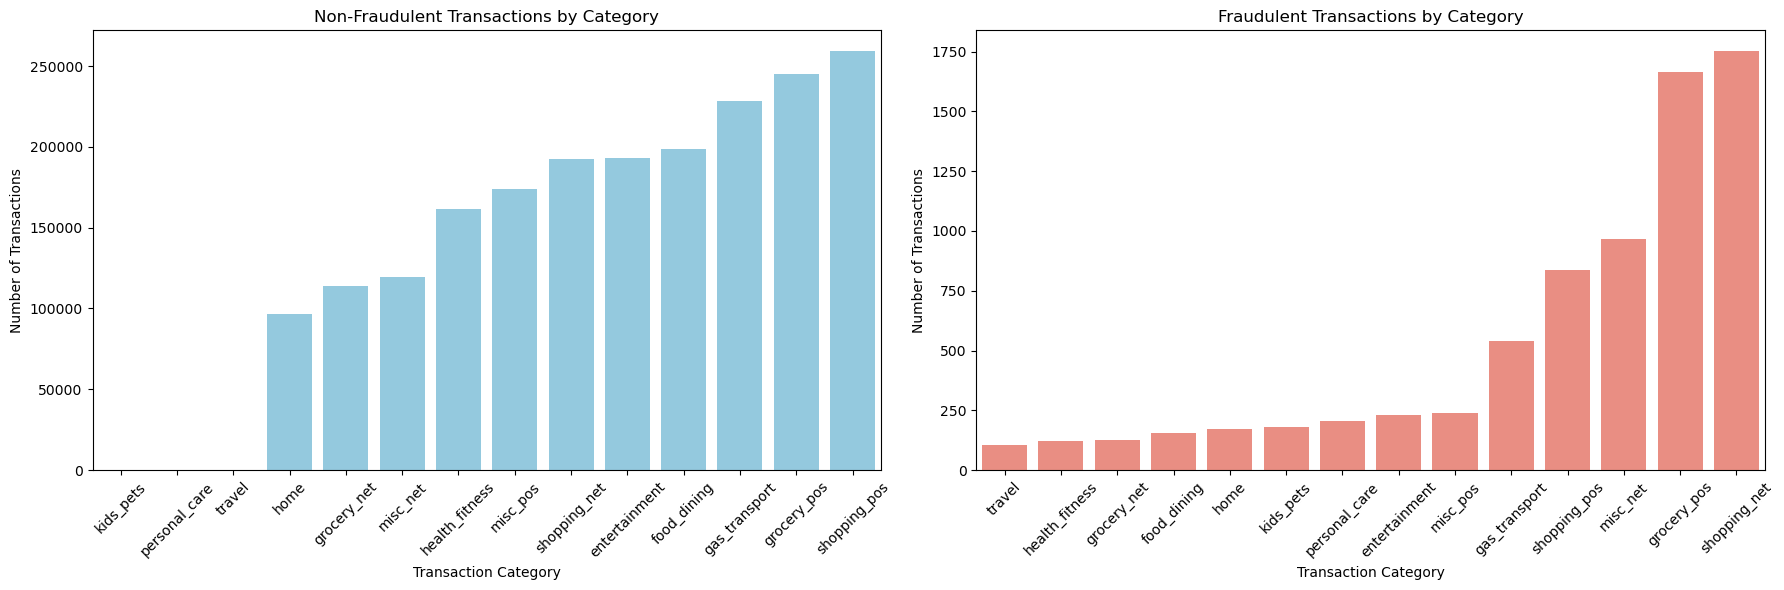

In [38]:
category_fraud = df1.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for category analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Non-Fraudulent Transactions by category
non_fraud = category_fraud.sort_values(by=0)
sns.barplot(x=non_fraud.index, y=non_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Category')
axes[0].set_xlabel('Transaction Category')
axes[0].set_ylabel('Number of Transactions')
axes[0].tick_params(axis='x', rotation=45)

# Plot Fraudulent Transactions by category
fraud = category_fraud.sort_values(by=1)
sns.barplot(x=fraud.index, y=fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Category')
axes[1].set_xlabel('Transaction Category')
axes[1].set_ylabel('Number of Transactions')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Proportion of fraudulent transactions by age group

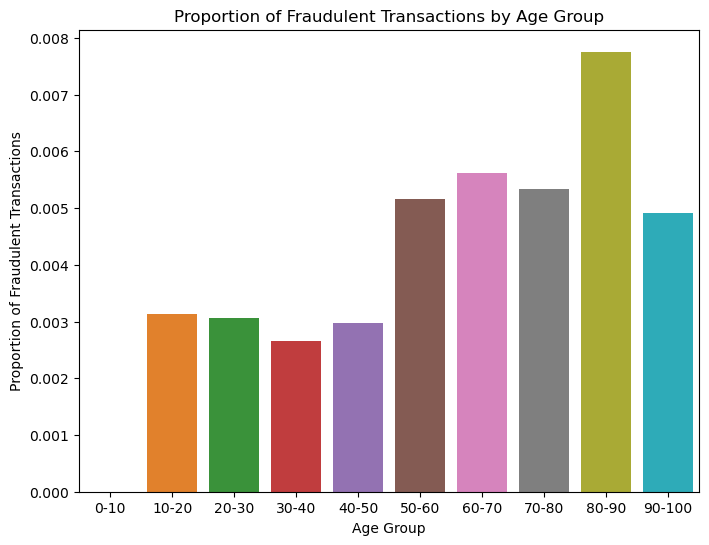

In [39]:
# Per age group analysis
age_fraud = df1.groupby('age_group')['is_fraud'].mean().reset_index()
age_fraud['is_fraud'] = age_fraud['is_fraud'].fillna(0)

# Plot Prportion of Fraudulent Transactions by age
plt.figure(figsize = (8, 6))
sns.barplot(data = age_fraud, x = 'age_group', y = 'is_fraud')
plt.title('Proportion of Fraudulent Transactions by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Proportion of Fraudulent Transactions')
plt.show()

### Fraudulent transaction by occupation

**Some occupations are prone to greater risk of fraudulent transactions than others**

Occupations that have a tendency to have strong earning power shows greater proportion of transactions being fraudulent, showing a tendency for fraudsters to target individuals with wealth

                                       job  is_fraud  total_count  \
29                     Art gallery manager        10           10   
354  Senior tax professional/tax inspector         8            8   
240  Medical laboratory scientific officer        21           21   
203                    Information officer        11           11   
204            Information systems manager        11           11   

     fraud_percentage  
29              100.0  
354             100.0  
240             100.0  
203             100.0  
204             100.0  


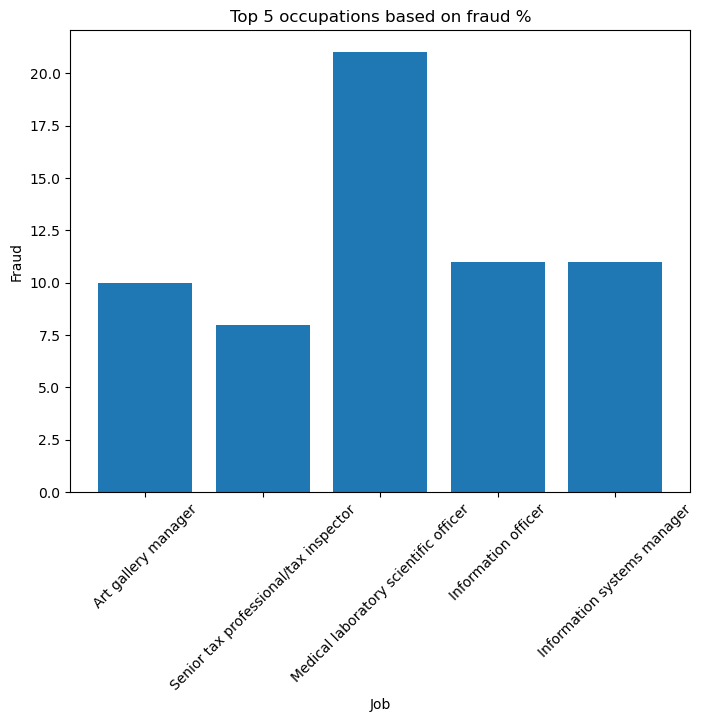

In [40]:
# x: city_state, y: fraud_count
# fraud count per city_pop, filter to a state to check
fraud_count = df1.groupby('job')['is_fraud'].sum().reset_index()

# Calculate total transactions by job
total_count = df1.groupby('job')['is_fraud'].count().reset_index()
total_count.rename(columns={'is_fraud': 'total_count'}, inplace=True)

# Merge fraud count and total count
fraud_percentage = pd.merge(fraud_count, total_count, on='job')

# Calculate percentage of fraud
fraud_percentage['fraud_percentage'] = (fraud_percentage['is_fraud'] / fraud_percentage['total_count']) * 100
top_5=fraud_percentage.sort_values(by='fraud_percentage',ascending=False).head(5)
print(top_5)
# show occupations with the highest % of frauds

plt.figure(figsize=(8, 6))
plt.bar('job','is_fraud', data=top_5) 
plt.title('Top 5 occupations based on fraud %')
plt.xlabel('Job')
plt.ylabel('Fraud')
plt.xticks(rotation=45)
plt.show()

### Fraudulent transactions by merchant


Merchants with highest fraud counts:
             merchant  fraud_count
468          Reichert          121
27           Baumbach           78
412          Mosciski           67
436  Pacocha-O'Reilly           49
194         Greenholt           49
17       Bailey-Morar           47
183  Goodwin-Nitzsche           46
251              Huel           46
24    Bashirian Group           45
487         Romaguera           44
Average fraud per merchant: 11.544303797468354
Median fraud per merchant: 5.0
Standard deviation fraud per merchant: 12.935499646228584


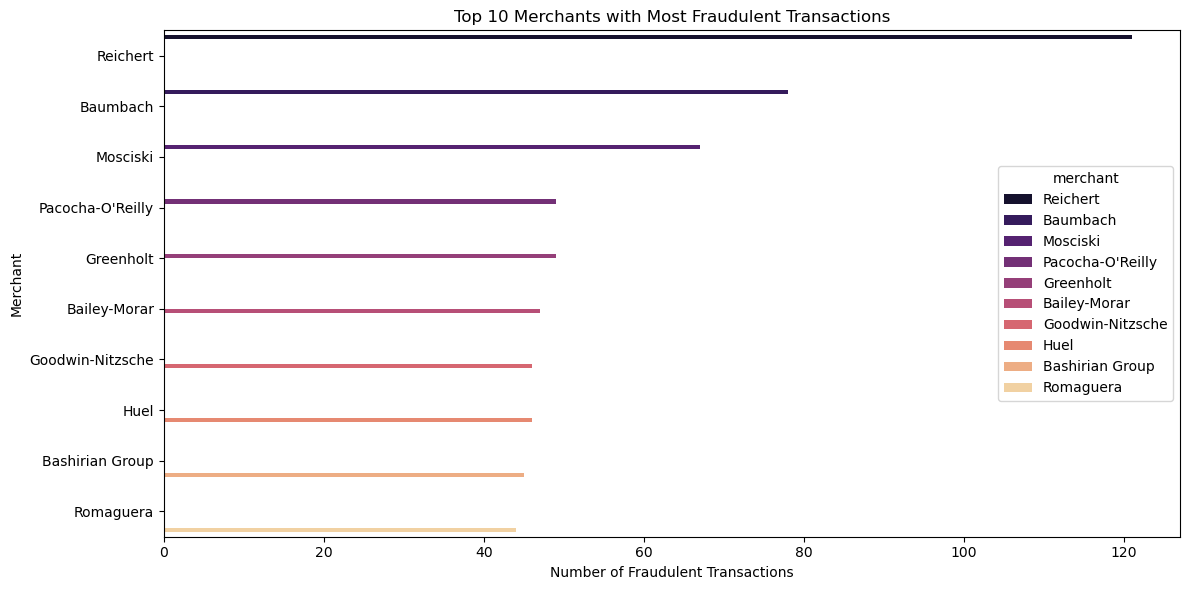


Analysis of top fraud merchants:
Merchant: Reichert
    Number of fraud transactions: 121
    Number of unique locations: 727
    Number of total customers: 11795
    Number of unique customers: 903
    Number of unique customers in fraud transactions: 110
    Average transaction amount: $73.28
    Most common transaction category: shopping_net
Merchant: Baumbach
    Number of fraud transactions: 78
    Number of unique locations: 723
    Number of total customers: 14077
    Number of unique customers: 900
    Number of unique customers in fraud transactions: 77
    Average transaction amount: $68.56
    Most common transaction category: shopping_pos
Merchant: Mosciski
    Number of fraud transactions: 67
    Number of unique locations: 723
    Number of total customers: 8753
    Number of unique customers: 897
    Number of unique customers in fraud transactions: 65
    Average transaction amount: $76.70
    Most common transaction category: grocery_pos


In [41]:
# Top merchants with fraudulent transactions
fraud_count_by_merchant = fraud_filter('merchant').sort_values(by='fraud_count', ascending=False)
print("Merchants with highest fraud counts:")
print(fraud_count_by_merchant.head(10))

# Calculate fraud summary stats for merchants
fraud_summary(fraud_count_by_merchant, 'merchant')

# Visualize top 10 merchants with most fraudulent transactions
top_fraud_merchants = fraud_count_by_merchant.nlargest(10, 'fraud_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='fraud_count', y='merchant', data=top_fraud_merchants, hue='merchant',palette='magma')
plt.title('Top 10 Merchants with Most Fraudulent Transactions')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Merchant')
plt.tight_layout()
plt.show()

# Detailed analysis of top fraud merchants
print("\nAnalysis of top fraud merchants:")
fraud_merchants = list(fraud_count_by_merchant['merchant'].head(3))
for m in fraud_merchants:
    temp = df1[df1['merchant'] == m]
    print(f'Merchant: {m}')
    print(f'    Number of fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].count()}')
    print(f'    Number of unique locations: {temp["city_state"].nunique()}')
    print(f'    Number of total customers: {temp["ssn"].count()}')
    print(f'    Number of unique customers: {temp["ssn"].nunique()}')
    print(f'    Number of unique customers in fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].nunique()}')
    avg_transaction_amount = temp['amt'].mean()
    print(f'    Average transaction amount: ${avg_transaction_amount:.2f}')
    most_common_category = temp['category'].mode()[0]  # take the first value
    print(f'    Most common transaction category: {most_common_category}')

In [42]:
least_fraud_m = fraud_count_by_merchant.sort_values(by='fraud_count', ascending=True)
least_fraud_m.head(10)

,merchant,fraud_count
338,Kutch-Hegmann,1
332,Kuphal-Toy,1
327,Kulas Group,1
367,Little-Gleichner,1
339,Kutch-Wilderman,1
502,Satterfield-Lowe,1
317,Kris-Kertzmann,1
439,Padberg-Sauer,1
471,Reilly and Sons,1
463,Rau-Robel,1


In [43]:
least_fraud_filter = least_fraud_m[least_fraud_m['fraud_count'] == 1]['merchant']

fraud_count_mc = fraud_filter(['merchant', 'ssn'])
fraud_count_mc = fraud_count_mc[fraud_count_mc['merchant'].isin(least_fraud_filter)]
fraud_count_mc.head()

,merchant,ssn,fraud_count
186,Bahringer-Streich,504142358,1
511,Bednar Inc,649608105,1
638,Bins-Howell,437446587,1
812,Boyer-Haley,96658934,1
1016,Champlin,673327172,1


### Fraudulent transactions by customers

In [44]:
# No. of unique customers based on ssn numbers (check why full names vs ssn/cc_num is different)
unique_customers = df1['ssn'].nunique()
print(f"Number of unique customers based on ssn: {unique_customers}")

fraud_customers_ssn = df1[df1['is_fraud'] == 1]['ssn'].nunique()
total_customers_ssn = df1['ssn'].nunique()

print(f"\nNumber of unique customers who committed fraud (based on SSN): {fraud_customers_ssn}")
print(f"Percentage of customers who committed fraud (based on SSN): {(fraud_customers_ssn/total_customers_ssn)*100:.2f}%")


Number of unique customers based on ssn: 972

Number of unique customers who committed fraud (based on SSN): 761
Percentage of customers who committed fraud (based on SSN): 78.29%


In [45]:
# 1. Bar plot of top 5 customers with highest number of transactions
top_customers_by_trans_count = df1.groupby('ssn').size().sort_values(ascending=False).head(5)


# 3. Top 5 customers with highest proportion of fraudulent transactions
# Total transactions per customer
total_trans_per_customer = df1.groupby('ssn').size()

# No. of fraudulent transactions per customer
fraud_trans_per_customer = df1[df1['is_fraud'] == 1].groupby('ssn').size()

# Calculate proportion of fraudulent transactions
fraud_proportion = pd.DataFrame({
    'total_transactions': total_trans_per_customer,
    'fraud_transactions': fraud_trans_per_customer
}).fillna(0)

fraud_proportion['fraud_ratio'] = fraud_proportion['fraud_transactions'] / fraud_proportion['total_transactions']

# Get top 5 customers with highest fraud ratio (with at least 1 fraud transaction)
top_fraud_ratio = fraud_proportion[fraud_proportion['fraud_transactions'] > 0].sort_values(
    'fraud_ratio', ascending=False).head(5)



In [46]:
# Print the actual numbers for reference
print("Top 5 customers with highest number of transactions:")
for ssn, count in zip(top_customers_by_trans_count.index, top_customers_by_trans_count.values):
    print(f"{ssn}: {count} transactions")

print("\nTop 5 customers with highest number of fraudulent transactions:")
for ssn, count in zip(fraud_counts.index, fraud_counts.values):
    print(f"{ssn}: {count} fraudulent transactions")

print("\nTop 5 customers with highest ratio of fraud:non-fraud transactions:")
for ssn, row in top_fraud_ratio.iterrows():
    print(f"{ssn}: {row['fraud_ratio']:.2%} ({int(row['fraud_transactions'])}/{int(row['total_transactions'])})")

Top 5 customers with highest number of transactions:
449246222: 5056 transactions
600568057: 5019 transactions
441231754: 5012 transactions
387483519: 5006 transactions
851087767: 5003 transactions

Top 5 customers with highest number of fraudulent transactions:
shopping_net: 1751 fraudulent transactions
grocery_pos: 1663 fraudulent transactions
misc_net: 966 fraudulent transactions
shopping_pos: 837 fraudulent transactions
gas_transport: 541 fraudulent transactions
misc_pos: 239 fraudulent transactions
entertainment: 230 fraudulent transactions
personal_care: 205 fraudulent transactions
kids_pets: 182 fraudulent transactions
home: 172 fraudulent transactions
food_dining: 157 fraudulent transactions
grocery_net: 125 fraudulent transactions
health_fitness: 121 fraudulent transactions
travel: 107 fraudulent transactions

Top 5 customers with highest ratio of fraud:non-fraud transactions:
891434968: 100.00% (7/7)
21222723: 100.00% (8/8)
873820773: 100.00% (7/7)
287502249: 100.00% (8/8)
38

Since a high number of customers solely have fraudulent pruchases, we further explored the spread of this ratio of fraud:non-fraud 

In [47]:
# Fraud:non-fraud ratio distribution across customers who had at least 1 fraudulent transaction

# Filter customers
customers_with_fraud = fraud_proportion[fraud_proportion['fraud_transactions'] > 0].copy()

# Create bins for fraud ratio
# Bin 1: 100% (all transactions are fraud)
# Bin 2: >50% and <100% (majority but not all are fraud)
# Bin 3: ≤50% (half or less are fraud)
bins = [0, 0.5, 0.99999, 1]
labels = ["≤50%", ">50% & <100%", "100%"]

# Categorize customers into bins
customers_with_fraud['fraud_bin'] = pd.cut(
    customers_with_fraud['fraud_ratio'], 
    bins=bins, 
    labels=labels, 
    right=True,
    include_lowest=True
)

# Count customers in each bin
bin_counts = customers_with_fraud['fraud_bin'].value_counts().sort_index()


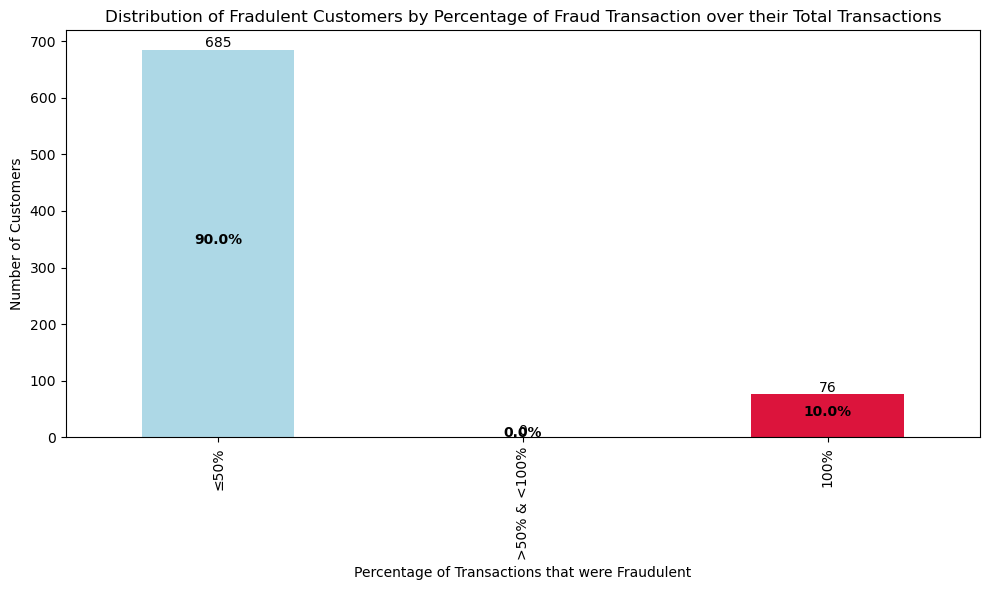

Total customers with at least one fraudulent transaction: 761
Customers with ≤50% fraudulent transactions: 685 (90.0%)
Customers with >50% & <100% fraudulent transactions: 0 (0.0%)
Customers with 100% fraudulent transactions: 76 (10.0%)


In [48]:
# Create the bar plot
plt.figure(figsize=(10, 6))
ax = bin_counts.plot(kind='bar', color=['lightblue', 'orange', 'crimson'])
plt.title('Distribution of Fradulent Customers by Percentage of Fraud Transaction over their Total Transactions')
plt.xlabel('Percentage of Transactions that were Fraudulent')
plt.ylabel('Number of Customers')

# Add count labels on top of each bar
for i, count in enumerate(bin_counts):
    plt.text(i, count + 5, str(count), ha='center')

# Add a percentage label inside each bar
total_customers = bin_counts.sum()
for i, count in enumerate(bin_counts):
    percentage = (count / total_customers) * 100
    plt.text(i, count/2, f"{percentage:.1f}%", ha='center', color='black', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total customers with at least one fraudulent transaction: {total_customers}")
for label, count in bin_counts.items():
    print(f"Customers with {label} fraudulent transactions: {count} ({count/total_customers*100:.1f}%)")

In [49]:
# Finding their first transaction 
customer_first_trans = df.sort_values(['ssn', 'trans_date', 'trans_time']).groupby('ssn').head(1)

# Count of fraudulent first transactions 
fraud_first_trans_count = customer_first_trans['is_fraud'].sum()

print(f"Number of customers whose first transaction was fraudulent: {fraud_first_trans_count}")
print(f"Percentage of customers whose first transaction was fraudulent: {(fraud_first_trans_count/total_customers_ssn) *100}")

Number of customers whose first transaction was fraudulent: 102
Percentage of customers whose first transaction was fraudulent: 10.493827160493826


In [50]:
fraud_count_mc.groupby('ssn')['ssn'].count() 

ssn
50096148     1
59318309     2
60794356     1
63417616     1
79807241     1
96658934     1
136674961    1
158063726    1
162088321    1
193015279    1
206427252    1
236758053    1
239783585    1
242807389    1
287991588    1
290344322    1
336956353    1
354090802    1
437446587    1
452579812    1
504142358    1
535016155    1
552207135    1
562639909    1
581884763    2
583658094    1
589058010    1
590868736    1
601895938    2
603456914    1
620492741    1
627469417    1
649608105    1
673327172    1
728359919    1
753562554    1
755111150    1
790880904    1
805105003    1
832275040    1
855200599    1
856593008    1
860084836    1
872333147    3
877448505    1
888842079    1
Name: ssn, dtype: int64

In [51]:
fraud_count_by_consumers = fraud_filter('ssn').sort_values(by='fraud_count', ascending=False)
fraud_count_by_consumers.head(10)

,ssn,fraud_count
551,648073243,19
568,672906422,18
753,887845439,16
593,705978209,16
597,711832839,16
642,753562554,16
218,243384277,16
213,236758053,16
368,461607650,16
152,158976908,16


In [52]:
least_fraud_c = fraud_count_by_consumers.sort_values(by='fraud_count', ascending=True)
least_fraud_c.head(10)

,ssn,fraud_count
167,182220390,2
418,505026947,2
433,525567036,2
487,581080162,2
500,590868736,2
371,465986615,2
111,117983404,3
612,720565684,3
393,483174238,3
680,795933171,3


### Fraudulent transactions by value

**Fraud involves larger sums**

Transaction between $500 to $1000 shows the highest proportion of fraudulent transaction and as such it could be used to create a new feature using transaction amount bins

In [53]:
labels = ['0-100', '100-500', '500-1000', '1000-5000', '>5000']
bins = [0, 100, 500, 1000, 5000, float('inf')]



# Create a new column with the range
df1['amt_range'] = pd.cut(df1['amt'], bins=bins, labels=labels, right=False)
df1.groupby('amt_range')['is_fraud'].mean()

amt_range
0-100        0.000931
100-500      0.006353
500-1000     0.162001
1000-5000    0.158122
>5000        0.000000
Name: is_fraud, dtype: float64

# Feature Engineering 

In [54]:
df2_train = train_df.copy()
df2_test = test_df.copy()

In [55]:
# Apply data cleaning (similar to EDA)

def clean_df(df):

    # Convert date and time to appropriate data types
    df['dob'] = pd.to_datetime(df['dob'], errors = 'coerce') 
    df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S')

    # Extract transaction time features
    week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['hour'] = df['trans_time'].dt.hour
    df['day_of_week'] = pd.Categorical(df['trans_date'].dt.day_name(), categories=week_order, ordered=True)
    df['month'] = df['trans_date'].dt.to_period('M').dt.to_timestamp()
    df["trans_quarter"] = pd.PeriodIndex(df['month'], freq='Q')
    df['year'] = df['trans_date'].dt.year
    df['trans_datetime'] = pd.to_datetime(df['trans_date'].dt.date.astype(str) + ' ' + df['trans_time'].dt.time.astype(str))

    # Sort df by ssn and transaction time
    df = df.sort_values(['ssn', 'trans_datetime'])

    # Calculate age at the time of the transaction (using function defined in `Data Preprocessing` section)
    df['age'] = df.apply(lambda x: calc_age(x), axis = 1)

    # Merge `city` and `state` columns
    df['city_state'] = df['city'] + ', ' + df['state']

    # Clean `merchant` feature
    df['merchant'] = df['merchant'].str.replace('fraud_','',regex=False)

    # Drop unused columns
    df = df.drop(columns=['first','last','cc_num', 'acct_num'])

    return df

df2_train = clean_df(df2_train)
df2_test = clean_df(df2_test)

* category_percentage_deviation = amount spent percentage deviation by category- to detect if any amount is above the usual non-fraudulent average for that category. 
* running count of fraud (for customer) - prev_trans_fraud, count_fraud_prev10, accumulative_fraud 
* running count of fraud (for merchant) - prev_trans_fraud, count_fraud_prev10, accumulative_fraud 
* holidays season's risk 
* indicator for whether category was visited in previous 100 transactions
* interval between current transaction and previous transaction (in seconds)
* current interval / median interval of past 75 transactions (or fewer if no data)
* current amount / mean transaction amount of past 75 transactions (or fewer if no data)



In [56]:
def category_avg_feature(df):
    category_avg = df[df['is_fraud'] == 0].groupby('category')['amt'].mean()
    
    # Store in dictionary for efficient lookup
    category_avg_dict = category_avg.to_dict()
    
    def calculate_deviation(row):
        cat_avg = category_avg_dict.get(row['category'], 0)
        percent_dev = ((row['amt'] - cat_avg) / cat_avg) * 100 if cat_avg != 0 else 0
        return percent_dev
    
    # Apply the deviation calculations
    df['category_percentage_deviation'] = df.apply(calculate_deviation, axis=1)
    
    return df

df2_train = category_avg_feature(df2_train)
df2_test = category_avg_feature(df2_test)

In [57]:
# for customers - prev_trans_fraud, count_fraud_prev10, accumulative_fraud

def customer_fraud_record(df):
    # To check if the customer's previous transaction was fraud
    df['prev_trans_fraud'] = 0

    # Group by ssn and process each customer's transactions
    for ssn, group in df.groupby('ssn'):
        prev_fraud = group['is_fraud'].shift(1) # Use shift function in pandas to get their previous transasction 
        prev_fraud = prev_fraud.fillna(0)
        df.loc[group.index, 'prev_trans_fraud'] = prev_fraud.astype(int)

    # Fraud in the past 10 transactions
    df['count_fraud_prev10'] = 0

    # Dictionary to store recent transactions by ssn
    ssn_recent_frauds = {}


    for idx, row in df.iterrows(): #use idx so we can use iterrows later
        ssn = row['ssn']
        is_fraud = row['is_fraud']
        
        if ssn not in ssn_recent_frauds:
            ssn_recent_frauds[ssn] = []
        
        fraud_count = sum(ssn_recent_frauds[ssn])
        df.at[idx, 'count_fraud_prev10'] = fraud_count
        ssn_recent_frauds[ssn].append(is_fraud)
        
        if len(ssn_recent_frauds[ssn]) > 10:
            ssn_recent_frauds[ssn].pop(0)  # Remove oldest, keep only the 10 most recent transactions


    # accumualtive fraud count
    df['acc_fraud_count'] = df.groupby('ssn')['is_fraud'].transform(
        lambda x: x.cumsum().shift(1).fillna(0).astype(int) #shift by 1 to exclude current transaction
    ) 

    return df

df2_train = customer_fraud_record(df2_train)
df2_test = customer_fraud_record(df2_test)

In [58]:
# for merchants - prev_trans_fraud, count_fraud_prev10, accumulative_fraud

def merchant_fraud_history(df):
    # Sort df by merchant and transaction date
    df = df.sort_values(['merchant', 'trans_datetime'])

    # merchant_prev_trans_fraud
    df['merchant_prev_trans_fraud'] = 0

    for merchant, group in df.groupby('merchant'):
        prev_fraud = group['is_fraud'].shift(1)
        prev_fraud = prev_fraud.fillna(0)
        df.loc[group.index, 'merchant_prev_trans_fraud'] = prev_fraud.astype(int)

    # merchant_count_fraud_prev10
    df['merchant_count_fraud_prev10'] = 0

    # Dictionary to store recent transactions by merchant
    merchant_recent_frauds = {}

    for idx, row in df.iterrows():
        merchant = row['merchant']
        is_fraud = row['is_fraud']
        
        if merchant not in merchant_recent_frauds:
            merchant_recent_frauds[merchant] = []
        
        fraud_count = sum(merchant_recent_frauds[merchant])
        df.at[idx, 'merchant_count_fraud_prev10'] = fraud_count
        merchant_recent_frauds[merchant].append(is_fraud)
        
        if len(merchant_recent_frauds[merchant]) > 10:
            merchant_recent_frauds[merchant].pop(0)  # Remove oldest, keep only the 10 most recent transactions

    # Merchant accumulative fraud 

    df['merchant_acc_fraud_count'] = df.groupby('merchant')['is_fraud'].transform(
        lambda x: x.cumsum().shift(1).fillna(0).astype(int) #shift by 1 to exclude current trans
    )

    return df

df2_train = merchant_fraud_history(df2_train)
df2_test = merchant_fraud_history(df2_test)

In [59]:
# peak spending period's risk 
def calculate_risk_score(df):
    """
    Risk Scoring Criteria:
    - High Risk (2): Nov 1st - Jan 7th (holiday period)
    - Medium Risk (1): 
      * June - August
      * Two weeks before November (Oct 18th - Oct 31st)
      * One week after Jan 7th (Jan 8th - Jan 14th)
    - Low Risk (0): All other periods
    """
    def _risk_score(month, day):
        # High-risk period (Holiday season)
        if (month.month == 11 and day >= 1) or \
           (month.month == 12) or \
           (month.month == 1 and day <= 7):
            return 2
        
        # Medium-risk periods (Summer months, June - August)
        if month.month in [6, 7, 8]:
            return 1
        
        # Two weeks before November (Oct 18 - Oct 31)
        if month.month == 10 and 18 <= day <= 31:
            return 1
        
        # One week after Jan 7th (Jan 8 - Jan 14)
        if month.month == 1 and 8 <= day <= 14:
            return 1
        
        return 0

    return df.apply(lambda row: _risk_score(row['month'], row['trans_date'].day), axis=1)

df2_train['transaction_risk_score'] = calculate_risk_score(df2_train)
df2_test['transaction_risk_score'] = calculate_risk_score(df2_test)

In [60]:
def calculate_hourly_risk_score(df, hour_col='hour'):
    # Calculate fraud counts and total transactions by hour
    hourly_stats = df.groupby(hour_col).agg(
        fraud_count=('is_fraud', 'sum'),
        transaction_count=('is_fraud', 'count')
    )
    # Convert to dictionaries
    fraud_counts = hourly_stats['fraud_count'].to_dict()
    total_transactions = hourly_stats['transaction_count'].to_dict()
    
    # Calculate fraud rates and thresholds; high risk (2), medium risk (1), and low risk (0)
    fraud_rates = {h: (fraud_counts.get(h, 0) / total_transactions.get(h, 1)) * 100 for h in range(24)}
    rates = np.array(list(fraud_rates.values()))
    high_threshold = np.percentile(rates, 90)
    medium_threshold = np.percentile(rates, 60)
 
    # Create risk mapping
    risk_map = {
        h: 2 if rate >= high_threshold else
           1 if rate >= medium_threshold else
           0
        for h, rate in fraud_rates.items()
    }

    return df[hour_col].map(risk_map).astype(int)

df2_train['hourly_risk_score'] = calculate_hourly_risk_score(df2_train)
df2_test['hourly_risk_score'] = calculate_hourly_risk_score(df2_test)

In [61]:
def trans_interval(df, w):
    # Find the interval between transactions
    freq_purchases = df.sort_values(['ssn', 'unix_time'])[['ssn', 'trans_num', 'unix_time', 'trans_quarter']]
    freq_purchases['prev_unix_time'] = freq_purchases.groupby('ssn').shift(1)['unix_time']
    freq_purchases['interval'] = freq_purchases['unix_time'] - freq_purchases['prev_unix_time']
    freq_purchases['prev_interval'] = freq_purchases.groupby('ssn').shift(1)['interval']
    freq_purchases = freq_purchases.sort_values(['ssn', 'unix_time'])

    # Find the median interval for each quarter (median to cancel out effects of any fraud transactions)
    def rolling_interval(series, window):
        queue = deque(maxlen=window) 
        result = []
        sl = SortedList()

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    sl.remove(removed)
                    
                queue.append(val)
                sl.add(val)
                
            if len(sl) % 2 == 1:
                result.append(sl[len(sl) // 2])
            elif len(sl) == 0:
                result.append(np.nan)
            else:
                result.append(sl[len(sl) // 2 - 1] + sl[len(sl) // 2] / 2)

        return result

    freq_purchases['rolling_median_interval']= freq_purchases.groupby('ssn')['prev_interval'].transform(lambda x: rolling_interval(x, w))

    # For first and second purchases, impute interval and rolling_median_interval with 0 and create column to indicate that this is first purchase
    freq_purchases['first_second_purchase'] = freq_purchases['prev_interval'].isna().astype(int)

    freq_purchases['rolling_median_interval'] = freq_purchases['rolling_median_interval'].fillna(0)
    freq_purchases['interval'] = freq_purchases['interval'].fillna(0)

    # Add 'interval' and 'prev_median_interval' columns to main df
    df = pd.merge(df, freq_purchases[['trans_num', 'interval', 'rolling_median_interval', 'first_second_purchase']], how = 'left', on = 'trans_num')

    # Compare each transaction's interval to the user's median interval in previous quarter
    df['interval_median_ratio'] = round(df['interval']/df['rolling_median_interval'], 2)
    
    # For first purchases, impute interval_median_ratio with 0
    df.loc[df['first_second_purchase'] == 1, 'interval_median_ratio'] = 0

    # Drop 'prev_median_interval' column
    df = df.drop(['rolling_median_interval'], axis = 1)

    return df

df2_train = trans_interval(df2_train, 75)
df2_test = trans_interval(df2_test, 75)

In [62]:
def categories_visited(df, w):
    # Sort transactions chronologically for each customer
    df = df.sort_values(['ssn', 'unix_time'])

    # Shift categories for each customer
    df['prev_cat'] = df.groupby('ssn')['category'].shift(1)

    # Function to track unique categories visited in rolling window
    def rolling_unique(series, window):
        queue = deque(maxlen=window) 
        seen = set()
        result = []

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    if removed not in queue:  
                        seen.discard(removed)

                queue.append(val)
                seen.add(val)

        
            result.append({value: 1 for value in seen})

        return result
    
    # Find unique categories visited up to 100 transacitons ago
    df['rolling_prev_cat'] = df.groupby('ssn')['prev_cat'].transform(lambda x: rolling_unique(x, w))
    # Create indicator for whether current transaction category has been visited before
    df['visited_cat'] = [int(bool(d.get(c))) if isinstance(d, dict) else None for d, c in zip(df['rolling_prev_cat'], df['category'])]
    # Drop columns for previous categories and shifted categories
    df = df.drop(['rolling_prev_cat', 'prev_cat'], axis = 1)
    
    return df

df2_train = categories_visited(df2_train, 75)
df2_test = categories_visited(df2_test, 75)

In [63]:
def mean_trans_amt(df, w):

    df = df.sort_values(['ssn', 'unix_time'])
    
    # Function to compute mean amount in rolling window
    def rolling_mean(series, window):
        queue = deque(maxlen=window) 
        result = []
        running_sum = 0

        for val in series:
            if pd.notna(val):
                if len(queue) == window:
                    removed = queue.popleft()
                    running_sum -= removed
                    
                queue.append(val)
                running_sum += val
                
            if len(queue) > 0:
                result.append(running_sum / len(queue)) 
            else:
                result.append(np.nan) 

        return result
    
    trans_amt = df[['ssn', 'category', 'trans_num', 'amt']]
    trans_amt['ssn_cat'] = trans_amt['ssn'].astype(str) + ' ' + trans_amt['category']
    trans_amt['prev_amt'] = trans_amt.groupby('ssn_cat').shift(1)['amt']
    trans_amt['cat_rolling_mean'] = trans_amt.groupby(['ssn_cat'])['prev_amt'].transform(lambda x: rolling_mean(x, w))

    # Find average value spent in each category across all time
    category_mean = df.groupby('category')['amt'].mean().to_dict()
    # Impute missing customer-specific categorc mean with global category mean 
    trans_amt['cat_rolling_mean'] = trans_amt['cat_rolling_mean'].fillna(trans_amt['category'].map(category_mean))

    # Add 'cat_rolling_mean' columns to main df
    df = pd.merge(df, trans_amt[['trans_num', 'cat_rolling_mean']], how = 'left', on = 'trans_num')

    # Compare each transaction's amount to the user's rolling mean transaction amount for that category
    df['amt_hist_ratio'] = round(df['amt']/df['cat_rolling_mean'], 2)

    # Drop 'cat_rolling_mean' column
    df = df.drop(['cat_rolling_mean'], axis = 1)

    return df

df2_train = mean_trans_amt(df2_train, 75)
df2_test = mean_trans_amt(df2_test, 75)

In [64]:
def city_population_size(df):
    city_population_bin = [0, 350000, 1000000, np.inf]

    labels = ["small", "medium", "large"]

    df.loc[:, "city_popluation_class"] = pd.cut(df.loc[:, "city_pop"], bins = city_population_bin, labels = labels)
    return df

df2_train = city_population_size(df2_train)
df2_test = city_population_size(df2_test)

In [65]:
def get_top_3_cities(df):
    city_ranking = df[["state", "city", "is_fraud"]].groupby(by = ["state", "city"], as_index = False).apply(lambda x: pd.Series({"city_fraud_proportion": x["is_fraud"].sum()/len(x)}))
    city_ranking.sort_values(by = ["state", "city_fraud_proportion"], inplace = True, ascending = False)
    top_3_cities = city_ranking.groupby(by = ["state"], as_index = False).head(3)
    df = df.merge(top_3_cities, how = "left", on = ["state", "city"])
    df["top_3_city"] = df["city_fraud_proportion"].apply(lambda x: 0 if x != x else 1)
    return df

df2_train = get_top_3_cities(df2_train)
df2_test = get_top_3_cities(df2_test)
                                    

In [66]:
# Drop columns not used
cols_to_drop = ['trans_date', 'city', 'dob', 'trans_time', 'unix_time', 'trans_num', 'trans_datetime']

df2_train = df2_train.drop(cols_to_drop, axis = 1)
df2_test = df2_test.drop(cols_to_drop, axis = 1)

In [68]:
# # Uncomment to save a copy of prepared train and test dfs into csv files
# df2_train.to_csv("../data/train_data.csv", index = False)
# df2_test.to_csv("../data/test_data.csv", index = False)